In [ ]:
#SKTime needs to be installed prior to use
!pip install pmdarima
!pip install sktime

In [ ]:
# Import Necessary Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.compose import ForecastingPipeline
from sktime.forecasting.model_selection import temporal_train_test_split, ForecastingGridSearchCV
from sklearn.pipeline import make_pipeline
from sktime.classification.distance_based import KNeighborsTimeSeriesClassifier
from sktime.classification.distance_based import ProximityForest
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sktime.forecasting.model_evaluation import evaluate
from sktime.forecasting.model_selection import ExpandingWindowSplitter, SlidingWindowSplitter
from sktime.datasets import load_lynx
from sktime.utils.plotting import plot_series, plot_windows
from  matplotlib.pyplot import boxplot
from sktime.performance_metrics.forecasting import mean_squared_error, mean_absolute_percentage_error
from sktime.transformations.series.difference import Differencer
from sklearn.metrics import balanced_accuracy_score
from scipy import signal
from sktime.classification.kernel_based import TimeSeriesSVC
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score

# hide warnings
import warnings
warnings.filterwarnings("ignore")
from sktime.classification.interval_based import SupervisedTimeSeriesForest

# Preprocessing

In [ ]:
# Import the csv file which contains the disolved oxygen data from your google drive

file_path = '/content/drive/MyDrive/ISAP 3001 A1/ts_panel_data.csv'
rawDO_Df = pd.read_csv(file_path)
rawDO_Df

,Bideford_2014,Enmore_2014,Kildare_2014,Mill_2014,Wheatley_2014,Bideford_2013,Bouctouche_2013,Dunk_2013,Enmore_2013,Kildare_2013,...,Murray_2019,Mill_2019,Wilmot_2019,Cocagne_2019,Pugwash_2019,Kouchibouguac_2019,Kouchibouguacis_2019,Pictou_(East)_2019,Pictou_(West)_2019,Bouctouche_2020
0,15.771,8.17,12.33,14.94,13.42,10.07,6.62,9.98,7.54,13.32,...,10.39,10.18,9.42,7.50,8.69,3.86,8.89,9.70,9.70,8.67
1,15.321,7.98,9.13,14.63,12.48,10.44,7.43,9.39,7.43,13.38,...,9.74,10.32,9.25,7.81,8.47,4.13,8.37,9.71,9.19,8.42
2,15.281,7.52,8.21,14.16,11.59,10.10,6.85,11.27,7.45,13.56,...,9.25,10.19,9.12,7.90,8.63,4.28,7.65,9.73,8.20,8.41
3,15.261,7.39,8.16,13.23,10.59,10.50,6.17,9.43,6.90,13.50,...,9.63,9.93,9.50,7.94,8.57,5.74,7.56,9.71,7.78,8.37
4,14.111,6.81,7.26,11.55,9.74,9.89,6.15,9.43,6.06,13.30,...,9.65,9.02,8.67,8.18,8.33,5.68,6.55,9.73,9.02,8.19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1604,11.871,11.05,0.00,20.58,13.33,10.00,9.46,10.26,11.38,0.00,...,5.91,11.64,0.63,9.73,8.61,7.65,9.56,9.15,7.82,9.42
1605,10.671,10.72,0.00,20.86,15.58,9.33,8.97,10.11,10.17,0.76,...,5.79,11.88,0.83,9.40,8.59,7.88,9.72,9.16,8.55,9.01
1606,10.711,9.94,0.00,16.61,15.27,8.48,9.03,10.63,11.09,10.21,...,6.10,11.54,0.95,9.75,8.41,8.43,8.81,9.16,8.56,8.93
1607,10.351,9.67,0.00,14.13,14.11,7.85,8.69,8.67,10.20,10.23,...,5.19,9.82,0.96,10.11,8.00,8.30,8.82,9.15,8.12,8.47


In [ ]:
# Import the csv file which contains the dates of the recorded dissolved oxygen levels from the file above

file_path = '/content/drive/MyDrive/ISAP 3001 A1/datatime_index.csv'
dates_Df = pd.read_csv(file_path)

rawDO_Df['datetime_index'] = pd.to_datetime(dates_Df[['year','month', 'day', 'hour']], format="%%m-%d %H")

rawDO_Df.set_index('datetime_index', inplace=True)
rawDO_Df

,Bideford_2014,Enmore_2014,Kildare_2014,Mill_2014,Wheatley_2014,Bideford_2013,Bouctouche_2013,Dunk_2013,Enmore_2013,Kildare_2013,...,Murray_2019,Mill_2019,Wilmot_2019,Cocagne_2019,Pugwash_2019,Kouchibouguac_2019,Kouchibouguacis_2019,Pictou_(East)_2019,Pictou_(West)_2019,Bouctouche_2020
datetime_index,,,,,,,,,,,,,,,,,,,,,
1900-07-01 11:00:00,15.771,8.17,12.33,14.94,13.42,10.07,6.62,9.98,7.54,13.32,...,10.39,10.18,9.42,7.50,8.69,3.86,8.89,9.70,9.70,8.67
1900-07-01 12:00:00,15.321,7.98,9.13,14.63,12.48,10.44,7.43,9.39,7.43,13.38,...,9.74,10.32,9.25,7.81,8.47,4.13,8.37,9.71,9.19,8.42
1900-07-01 13:00:00,15.281,7.52,8.21,14.16,11.59,10.10,6.85,11.27,7.45,13.56,...,9.25,10.19,9.12,7.90,8.63,4.28,7.65,9.73,8.20,8.41
1900-07-01 14:00:00,15.261,7.39,8.16,13.23,10.59,10.50,6.17,9.43,6.90,13.50,...,9.63,9.93,9.50,7.94,8.57,5.74,7.56,9.71,7.78,8.37
1900-07-01 15:00:00,14.111,6.81,7.26,11.55,9.74,9.89,6.15,9.43,6.06,13.30,...,9.65,9.02,8.67,8.18,8.33,5.68,6.55,9.73,9.02,8.19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1900-09-06 07:00:00,11.871,11.05,0.00,20.58,13.33,10.00,9.46,10.26,11.38,0.00,...,5.91,11.64,0.63,9.73,8.61,7.65,9.56,9.15,7.82,9.42
1900-09-06 08:00:00,10.671,10.72,0.00,20.86,15.58,9.33,8.97,10.11,10.17,0.76,...,5.79,11.88,0.83,9.40,8.59,7.88,9.72,9.16,8.55,9.01
1900-09-06 09:00:00,10.711,9.94,0.00,16.61,15.27,8.48,9.03,10.63,11.09,10.21,...,6.10,11.54,0.95,9.75,8.41,8.43,8.81,9.16,8.56,8.93


In [ ]:
# Find the highest, second highest, second lowest, and lowest standard deviation of the time series as these are the four time series this project focuses on
stdValues = rawDO_Df.std()
lowestStd = stdValues.sort_values()[0:1]
highestStd = stdValues.sort_values()[-1:]
secondLowestStd = stdValues.sort_values()[1:2]
secondHighestStd = stdValues.sort_values(ascending=False)[1:2]

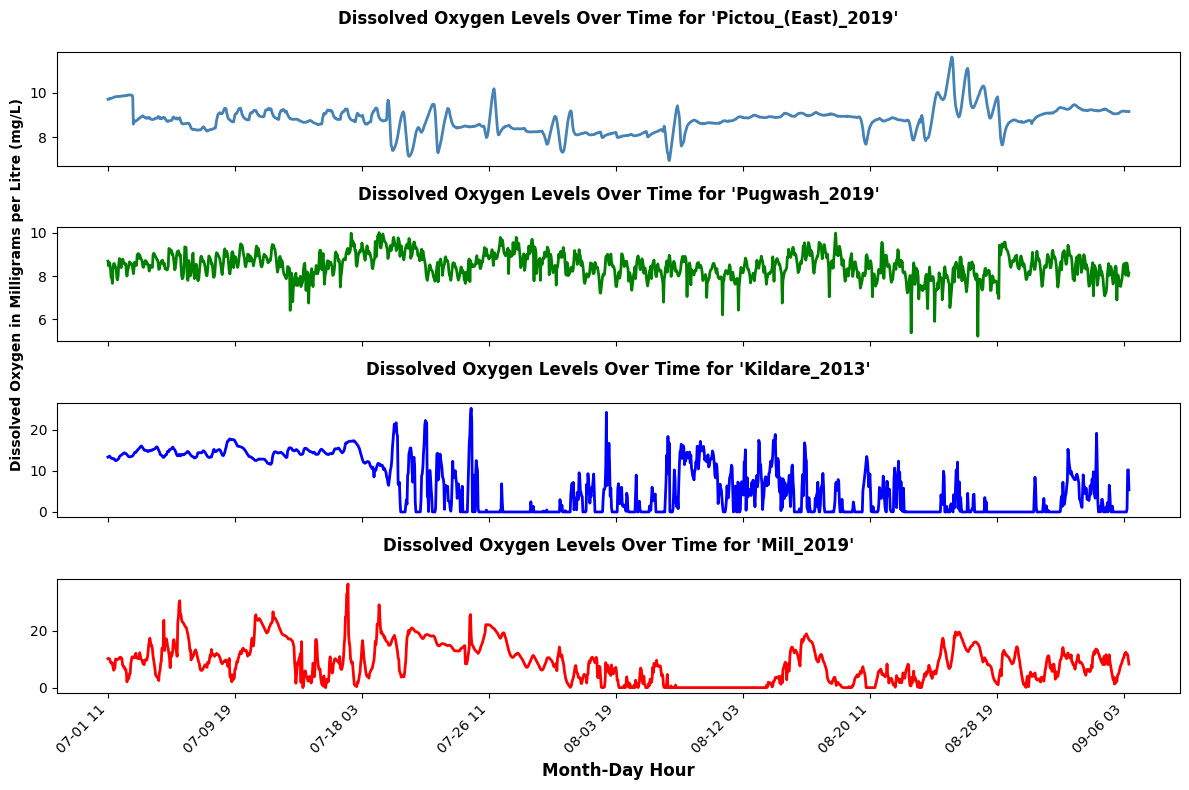

In [ ]:
# Graph the four time series described above in order to have a better understanding of the data that we are working with
# Copy DataFrame and format index
copy_rawDO_Df = rawDO_Df.copy()
copy_rawDO_Df.index = copy_rawDO_Df.index.strftime('%m-%d %H')

# Create subplots
fig, axarr = plt.subplots(4, sharex=True)
fig.set_size_inches(12, 8)

# Plot each graph with specified settings
copy_rawDO_Df[[lowestStd.index[0]]].plot(ax=axarr[0], linewidth=2, color='steelblue', legend=False)
axarr[0].set_title(f"Dissolved Oxygen Levels Over Time for '{lowestStd.index[0]}'", fontsize=12, fontweight='bold', pad=20)

copy_rawDO_Df[[secondLowestStd.index[0]]].plot(ax=axarr[1], linewidth=2, color='g', legend=False)
axarr[1].set_title(f"Dissolved Oxygen Levels Over Time for '{secondLowestStd.index[0]}'", fontsize=12, fontweight='bold', pad=20)
axarr[1].set_ylabel("Dissolved Oxygen in Milligrams per Litre (mg/L)", fontweight='bold', fontsize=10)

copy_rawDO_Df[[secondHighestStd.index[0]]].plot(ax=axarr[2], linewidth=2, color='b', legend=False)
axarr[2].set_title(f"Dissolved Oxygen Levels Over Time for '{secondHighestStd.index[0]}'", fontsize=12, fontweight='bold', pad=20)

copy_rawDO_Df[[highestStd.index[0]]].plot(ax=axarr[3], linewidth=2, color='r', legend=False)
axarr[3].set_title(f"Dissolved Oxygen Levels Over Time for '{highestStd.index[0]}'", fontsize=12, fontweight='bold', pad=20)
axarr[3].set_xlabel("Month-Day Hour", fontsize=12, fontweight='bold')

# Format the x-axis dates
plt.gcf().autofmt_xdate(rotation=45)

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()


In [ ]:
# smooth data by removing tidal impacts
def do_low_pass_filter(X):
  '''X: Time series DataFrame for of DO site'''
  #Low-pass filter parameters
  i_cycle_length= 24
  fs=1 #1 hour in Hz (sampling frequency)
  b, a = signal.butter(5, fs/i_cycle_length, btype='lowpass') #low pass filter
  i_fullSize = rawDO_Df.shape[0]
  #Apply the low-pass filter to selected site
  dUfilt = signal.filtfilt(b, a, X)

  #Save filtered data as dataframe
  dUfilt=np.array(dUfilt)
  dUfilt=dUfilt.transpose()
  return dUfilt

In [ ]:
# Create a dataframe for the lowest standard deviation time series with the low pass filter applied

df_loweststd = do_low_pass_filter(rawDO_Df[lowestStd.index[0]])
df_loweststd = pd.DataFrame(df_loweststd )
df_loweststd.columns = [lowestStd.index[0]]
df_loweststd.index = rawDO_Df.index
df_loweststd.head()

,Pictou_(East)_2019
datetime_index,
1900-07-01 11:00:00,9.694815
1900-07-01 12:00:00,9.709279
1900-07-01 13:00:00,9.724222
1900-07-01 14:00:00,9.739532
1900-07-01 15:00:00,9.755084


In [ ]:
# Add the year 2019 to this time series as the time series does not keep track of the year

# Convert the index to a regular series first, then use .map() to modify the dates
df_loweststd.index = df_loweststd.index.to_series().map(lambda d: d.replace(year=2019))

df_loweststd

,Pictou_(East)_2019
datetime_index,
2019-07-01 11:00:00,9.694815
2019-07-01 12:00:00,9.709279
2019-07-01 13:00:00,9.724222
2019-07-01 14:00:00,9.739532
2019-07-01 15:00:00,9.755084
...,...
2019-09-06 07:00:00,9.109831
2019-09-06 08:00:00,9.110075
2019-09-06 09:00:00,9.110323


In [ ]:
# Create a dataframe for the second lowest standard deviation time series with the low pass filter applied

df_secondLoweststd = do_low_pass_filter(rawDO_Df[secondLowestStd.index[0]])
df_secondLoweststd = pd.DataFrame(df_secondLoweststd )
df_secondLoweststd.columns = [secondLowestStd.index[0]]
df_secondLoweststd.index = rawDO_Df.index
df_secondLoweststd.head()

,Pugwash_2019
datetime_index,
1900-07-01 11:00:00,8.714994
1900-07-01 12:00:00,8.686557
1900-07-01 13:00:00,8.657584
1900-07-01 14:00:00,8.628387
1900-07-01 15:00:00,8.599278


In [ ]:

# Convert the index to a regular series first, then use .map() to modify the dates
df_secondLoweststd.index = df_secondLoweststd.index.to_series().map(lambda d: d.replace(year=2019))

df_secondLoweststd

,Pugwash_2019
datetime_index,
2019-07-01 11:00:00,8.714994
2019-07-01 12:00:00,8.686557
2019-07-01 13:00:00,8.657584
2019-07-01 14:00:00,8.628387
2019-07-01 15:00:00,8.599278
...,...
2019-09-06 07:00:00,8.087713
2019-09-06 08:00:00,8.089913
2019-09-06 09:00:00,8.091798


In [ ]:
# Create a dataframe for the second highest standard deviation time series with the low pass filter applied

df_secondHigheststd = do_low_pass_filter(rawDO_Df[secondHighestStd.index[0]])
df_secondHigheststd = pd.DataFrame(df_secondHigheststd )
df_secondHigheststd.columns = [secondHighestStd.index[0]]
df_secondHigheststd.index = rawDO_Df.index
df_secondHigheststd.head()

,Kildare_2013
datetime_index,
1900-07-01 11:00:00,13.340416
1900-07-01 12:00:00,13.316039
1900-07-01 13:00:00,13.292143
1900-07-01 14:00:00,13.269080
1900-07-01 15:00:00,13.247195


In [ ]:
# Convert the index to a regular series first, then use .map() to modify the dates
df_secondHigheststd.index = df_secondHigheststd.index.to_series().map(lambda d: d.replace(year=2013))

df_secondHigheststd

,Kildare_2013
datetime_index,
2013-07-01 11:00:00,13.340416
2013-07-01 12:00:00,13.316039
2013-07-01 13:00:00,13.292143
2013-07-01 14:00:00,13.269080
2013-07-01 15:00:00,13.247195
...,...
2013-09-06 07:00:00,1.314564
2013-09-06 08:00:00,1.364151
2013-09-06 09:00:00,1.408804


In [ ]:
# Create a dataframe for the highest standard deviation time series with the low pass filter applied

df_higheststd = do_low_pass_filter(rawDO_Df[highestStd.index[0]])
df_higheststd = pd.DataFrame(df_higheststd )
df_higheststd.columns = [highestStd.index[0]]
df_higheststd.index = rawDO_Df.index
df_higheststd.head()

,Mill_2019
datetime_index,
1900-07-01 11:00:00,10.590650
1900-07-01 12:00:00,10.482562
1900-07-01 13:00:00,10.364240
1900-07-01 14:00:00,10.236333
1900-07-01 15:00:00,10.099594


In [ ]:
# Convert the index to a regular series first, then use .map() to modify the dates
df_higheststd.index = df_higheststd.index.to_series().map(lambda d: d.replace(year=2019))

df_higheststd

,Mill_2019
datetime_index,
2019-07-01 11:00:00,10.590650
2019-07-01 12:00:00,10.482562
2019-07-01 13:00:00,10.364240
2019-07-01 14:00:00,10.236333
2019-07-01 15:00:00,10.099594
...,...
2019-09-06 07:00:00,6.753715
2019-09-06 08:00:00,6.790774
2019-09-06 09:00:00,6.824340


In [ ]:
'''We can use the shift() function in Pandas to automatically create a new
framing of a time series problems given the desired length of input and output
sequences.'''

#Tabularize
def series_to_tabular(ts, n_in, fh=1):
  ''' - ts: is the time series
      - n_in: is the number of variables (time steps)
    in the tabular data
      - fh: is the forecast horizon. The default says
    predict the next time step'''

  # Make a list of shifted versions of ts
  cols = list()
  # input sequence (t-n-1, ... t)
  for i in range(n_in-1, -1, -1):
    cols.append(ts.shift(i))

  # append the targets to the list
  cols.append(ts.shift(-fh))

  # convert the list to a DataFame
  X = pd.concat(cols, axis=1)

  # drop rows with NaN values
  X.dropna(inplace=True)

  # create the column headings
  X.columns = ["t-" + str(i) \
               for i in range(n_in, 0, -1)] + ['fh']
  return X

The next 4 code block plot both the origional time series with the updated time series now that the time series has a low pass filter apploer

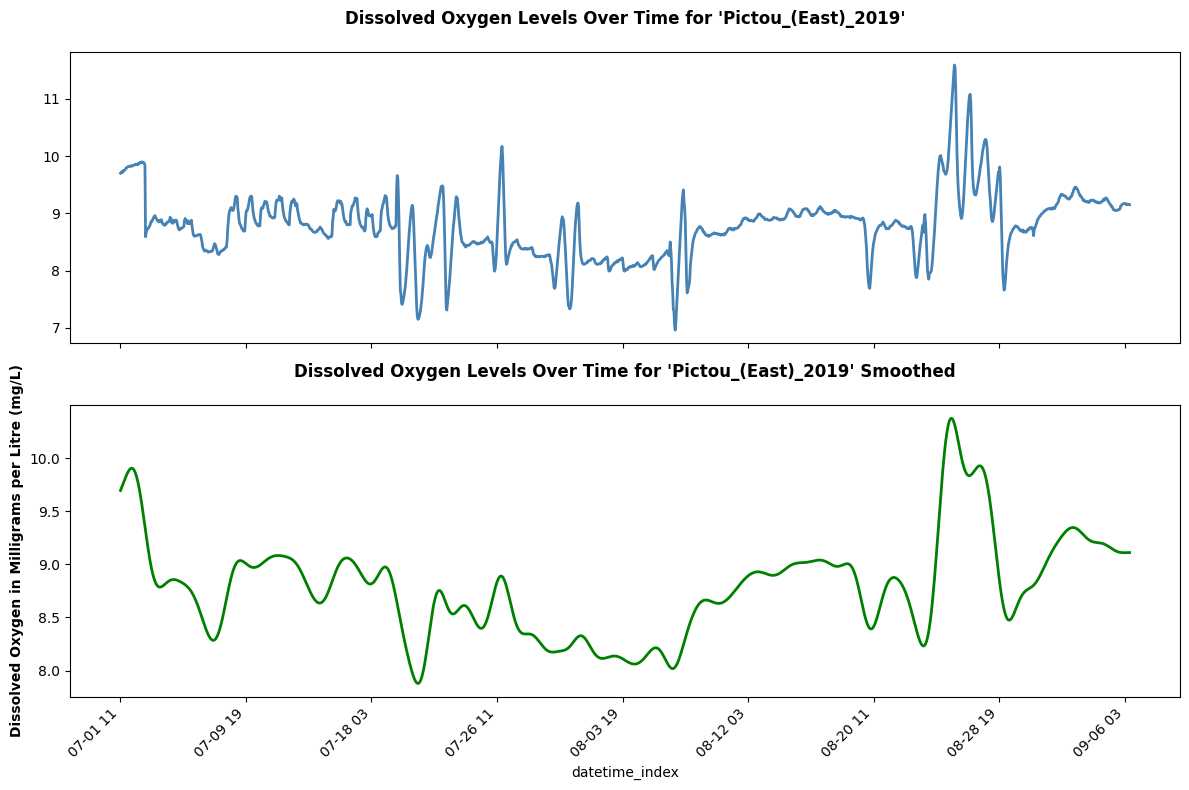

In [ ]:
# Copy DataFrame and format index
copy_rawDO_Df = rawDO_Df.copy()
copy_rawDO_Df.index = copy_rawDO_Df.index.strftime('%m-%d %H')

# Create subplots
fig, axarr = plt.subplots(2, sharex=True)
fig.set_size_inches(12, 8)

df_loweststd_copy = df_loweststd.copy()

df_loweststd_copy.index = df_loweststd_copy.index.strftime('%m-%d %H')


# Plot each graph with specified settings
copy_rawDO_Df[[lowestStd.index[0]]].plot(ax=axarr[0], linewidth=2, color='steelblue', legend=False)
axarr[0].set_title(f"Dissolved Oxygen Levels Over Time for '{lowestStd.index[0]}'", fontsize=12, fontweight='bold', pad=20)

df_loweststd_copy.plot(ax=axarr[1], linewidth=2, color='g', legend=False)
axarr[1].set_title(f"Dissolved Oxygen Levels Over Time for '{lowestStd.index[0]}' Smoothed", fontsize=12, fontweight='bold', pad=20)
axarr[1].set_ylabel("Dissolved Oxygen in Milligrams per Litre (mg/L)", fontweight='bold', fontsize=10)  # Y-label on the middle graph


# Format the x-axis dates
plt.gcf().autofmt_xdate(rotation=45)

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()




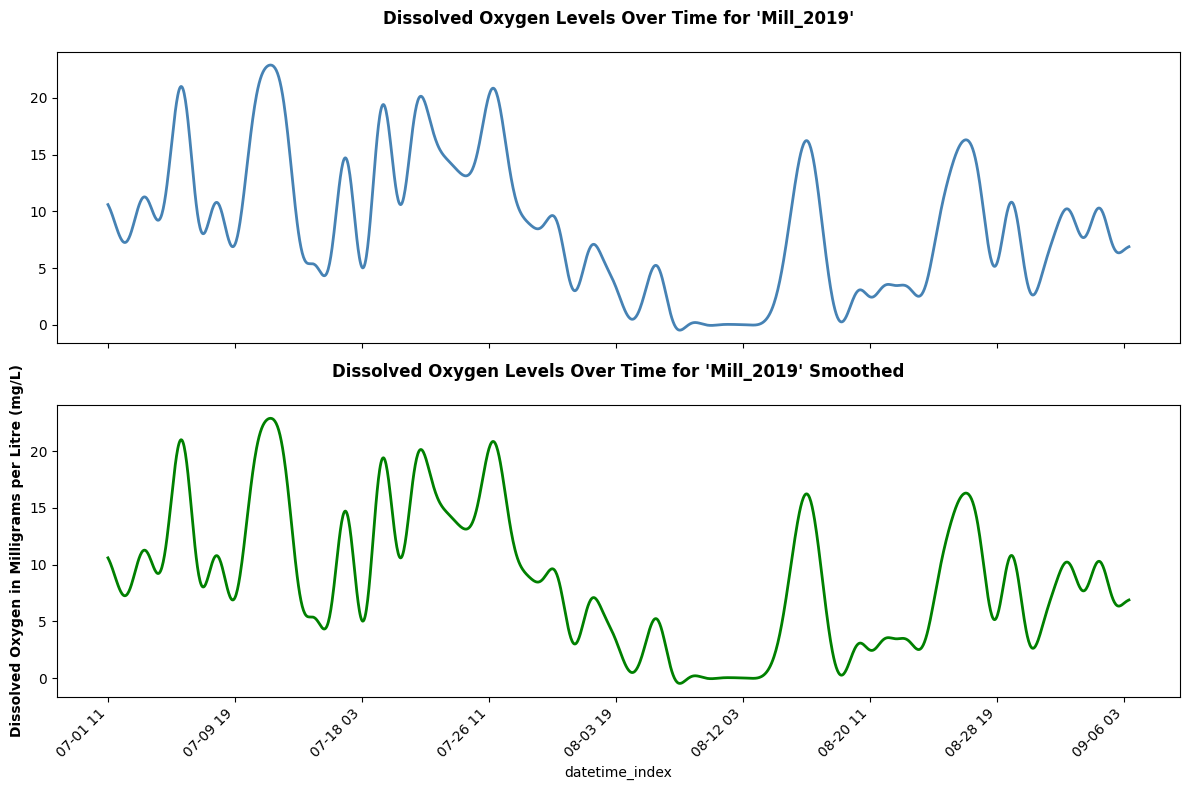

In [ ]:
# Copy DataFrame and format index
copy_rawDO_Df = df_higheststd.copy()
copy_rawDO_Df.index = copy_rawDO_Df.index.strftime('%m-%d %H')

# Create subplots
fig, axarr = plt.subplots(2, sharex=True)
fig.set_size_inches(12, 8)

df_higheststd_copy = df_higheststd.copy()

df_higheststd_copy.index = df_higheststd_copy.index.strftime('%m-%d %H')


# Plot each graph with specified settings
copy_rawDO_Df[[highestStd.index[0]]].plot(ax=axarr[0], linewidth=2, color='steelblue', legend=False)
axarr[0].set_title(f"Dissolved Oxygen Levels Over Time for '{highestStd.index[0]}'", fontsize=12, fontweight='bold', pad=20)

df_higheststd_copy.plot(ax=axarr[1], linewidth=2, color='g', legend=False)
axarr[1].set_title(f"Dissolved Oxygen Levels Over Time for '{highestStd.index[0]}' Smoothed", fontsize=12, fontweight='bold', pad=20)
axarr[1].set_ylabel("Dissolved Oxygen in Milligrams per Litre (mg/L)", fontweight='bold', fontsize=10)  # Y-label on the middle graph


# Format the x-axis dates
plt.gcf().autofmt_xdate(rotation=45)

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()



In [ ]:
#Add class labels to dataframe
def make_class_labels(tabTS, cls_boundaries, cls_names):
  ''' Take the tabularized data with column names ...t-2,t-1,th
    and add a column Class with class labels based on the values in
    column th and the boundaries in cls_boundaries'''

  tabTS["Class"] = [cls_names[0]]*len(tabTS)
  for b in range(len(cls_boundaries)):
    tabTS.loc[(tabTS['fh']>cls_boundaries[b]),'Class'] = cls_names[b+1]
  tabTS['Class'].astype("category")
  return tabTS


We have 1609 time series values in the data


(<Figure size 1600x480 with 1 Axes>,
 <Axes: xlabel='Time', ylabel='Window number'>)

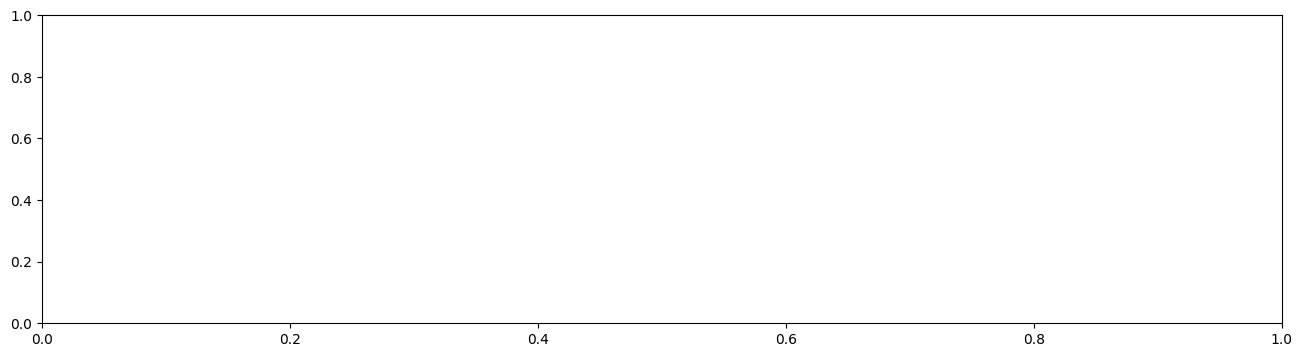

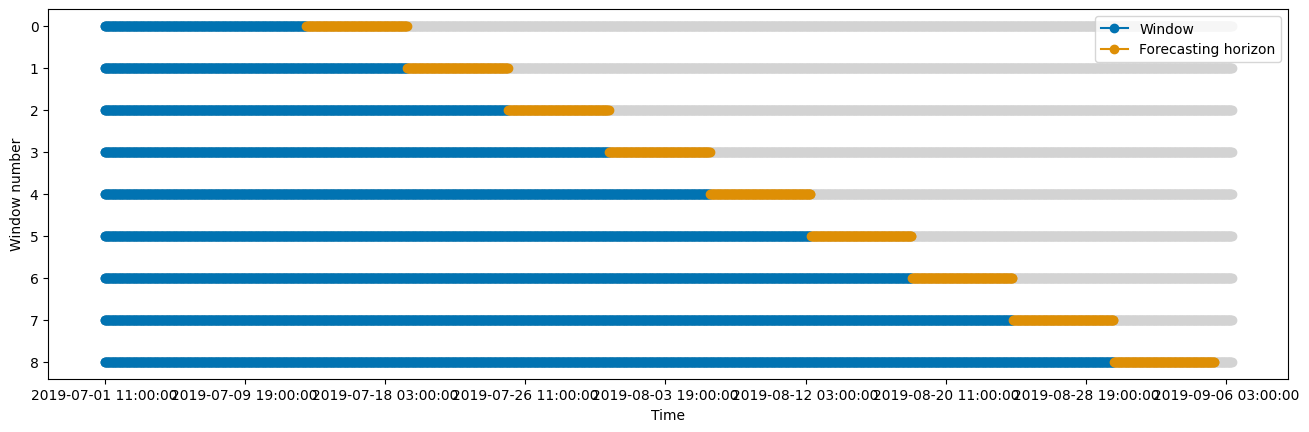

In [ ]:
print("We have %i time series values in the data" % df_loweststd.shape[0])


# Create a time series cross-validator
splitter = ExpandingWindowSplitter(step_length=144, fh=(np.arange(144)+1).tolist(),initial_window = 288)


plot_windows(splitter, df_loweststd)

# Classifiction Models

# Lowest Standard Deviation

Throught the next many code blocks the code has a lot of repetition. For each of the four time series we build the three classifiction models:



1.   K-Nearest Neighbour
2.   Support Vector Machine
3.   Random Forest Classifier

# KNN

In [ ]:
# define classes
cls_boundaries = np.quantile(df_loweststd, [.25, .75])
print("We discretize the data into low, medium and high at " + str(cls_boundaries))

We discretize the data into low, medium and high at [8.44194747 9.01636072]


In [ ]:
# Specify the hyper-parameters to try
in_sizes = [48,72,96,120]
n_neighbors =  [3,5,7,9]
distances    =  ["euclidean", "dtw"]
doScale = True
# Forecast horizone - 24 time steps in the future (one week ahead)
fh = 24

In [ ]:
# manually keep track of results of temporal CV
scores = []
names = []
sum_confusion_matrices = []
dat = df_loweststd[df_loweststd.columns[0]].copy()
# Grid search over all hyper-parameter combinations
for ins in in_sizes: # number of predictor inputs
  for nn in n_neighbors: # number of nearest neigbours to use
    for dist in distances: # distance function to use
      cv = list(splitter.split(dat))
      tmp_score = []
      names += [["knn", "ft_" + str(fh),
                 "InSize_" + str(ins),
                 "nn_" + str(nn),
                 "distance_" + dist]]
      confusion_matrices = []
      for fold in cv: #iterate over the folds of CV
        trn_data = series_to_tabular(dat[fold[0]],
                                     n_in=ins,
                                     fh=fh) #tabularize the training data
        trn_data =  make_class_labels(trn_data,
                                      cls_boundaries,
                                       ["Low", "Medium", "High"]) # discretize the training targets
        tst_data = series_to_tabular(dat[fold[1]],
                                     n_in=ins,
                                     fh=fh) # discretize the testing targets
        tst_data =  make_class_labels(tst_data,
                                      cls_boundaries,
                                       ["Low", "Medium", "High"]) #tabularize the testing data

        if doScale:
          #make a pipeline to scale the data and train kNN classifier
          classifier = make_pipeline(StandardScaler(),
                                     KNeighborsTimeSeriesClassifier(n_neighbors=nn,
                                                                    distance=dist))
        else:
          #make a pipeline to scale the data and train kNN classifier
          classifier = make_pipeline(KNeighborsTimeSeriesClassifier(n_neighbors=nn,
                                                                    distance=dist))
        #fit the classifier
        classifier.fit(trn_data.iloc[:,:ins].values, trn_data['Class'])
        #make predictions and calculate test accuracy
        y_pred = classifier.predict(tst_data.iloc[:,:ins].values)
        # Create a confusion matrix
        cm = confusion_matrix(tst_data['Class'], y_pred, labels=["Low", "Medium", "High"])
        # Add the confusion matrix values to an array
        confusion_matrices += [cm]

        tmp_score += [accuracy_score(tst_data['Class'], y_pred)]
      scores += [tmp_score]
      sum_confusion_matrices+=[sum(confusion_matrices)]

res = np.concatenate((np.mean(np.vstack(scores),axis=1).reshape(-1,1),
                      np.std(np.vstack(scores),axis=1).reshape(-1,1)),axis=1)
resDf = pd.DataFrame(res)
resDf.columns = ['Mean', 'Std']
namesDf = pd.DataFrame(names)
resDf = pd.concat([namesDf, resDf], axis=1)
resDf

,0,1,2,3,4,Mean,Std
0,knn,ft_24,InSize_48,nn_3,distance_euclidean,0.424658,0.265312
1,knn,ft_24,InSize_48,nn_3,distance_dtw,0.525114,0.265312
2,knn,ft_24,InSize_48,nn_5,distance_euclidean,0.420091,0.262468
3,knn,ft_24,InSize_48,nn_5,distance_dtw,0.526636,0.266732
4,knn,ft_24,InSize_48,nn_7,distance_euclidean,0.418569,0.257747
5,knn,ft_24,InSize_48,nn_7,distance_dtw,0.520548,0.269213
6,knn,ft_24,InSize_48,nn_9,distance_euclidean,0.414003,0.253561
7,knn,ft_24,InSize_48,nn_9,distance_dtw,0.515982,0.264998
8,knn,ft_24,InSize_72,nn_3,distance_euclidean,0.489796,0.380952
9,knn,ft_24,InSize_72,nn_3,distance_dtw,0.557823,0.335754


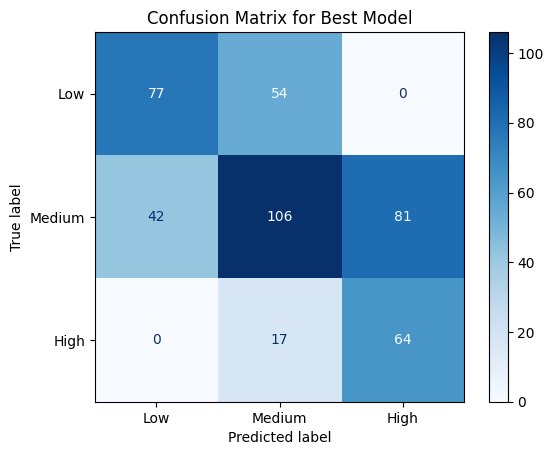

In [ ]:
best_model_idx = np.argmax(np.mean(np.vstack(scores), axis=1))
best_confusion_matrix = sum_confusion_matrices[best_model_idx]

# Create a confusion matrix display for the best model
disp = ConfusionMatrixDisplay(confusion_matrix=best_confusion_matrix, display_labels=["Low", "Medium", "High"])

# Plot the confusion matrix for the best model
disp.plot(cmap='Blues')
plt.title("Confusion Matrix for Best Model")
plt.show()


In [ ]:
resDf['Model_Setup'] = resDf.iloc[:, :5].apply(lambda row: '_'.join(row.astype(str)), axis=1)

# Set the new column as the index if desired
resDf.set_index('Model_Setup', inplace=True)


# Drop the first 5 columns
resDf.drop(resDf.columns[:5], axis=1, inplace=True)

df_sorted = resDf.sort_values(by='Mean', ascending=False)

df_sorted

,Mean,Std
Model_Setup,,
knn_ft_24_InSize_72_nn_5_distance_dtw,0.560091,0.340287
knn_ft_24_InSize_72_nn_3_distance_dtw,0.557823,0.335754
knn_ft_24_InSize_120_nn_3_distance_dtw,0.555556,0.496904
knn_ft_24_InSize_72_nn_7_distance_dtw,0.555556,0.342411
knn_ft_24_InSize_120_nn_9_distance_dtw,0.555556,0.496904
knn_ft_24_InSize_120_nn_5_distance_dtw,0.555556,0.496904
knn_ft_24_InSize_120_nn_7_distance_dtw,0.555556,0.496904
knn_ft_24_InSize_72_nn_9_distance_dtw,0.555556,0.342141
knn_ft_24_InSize_48_nn_5_distance_dtw,0.526636,0.266732


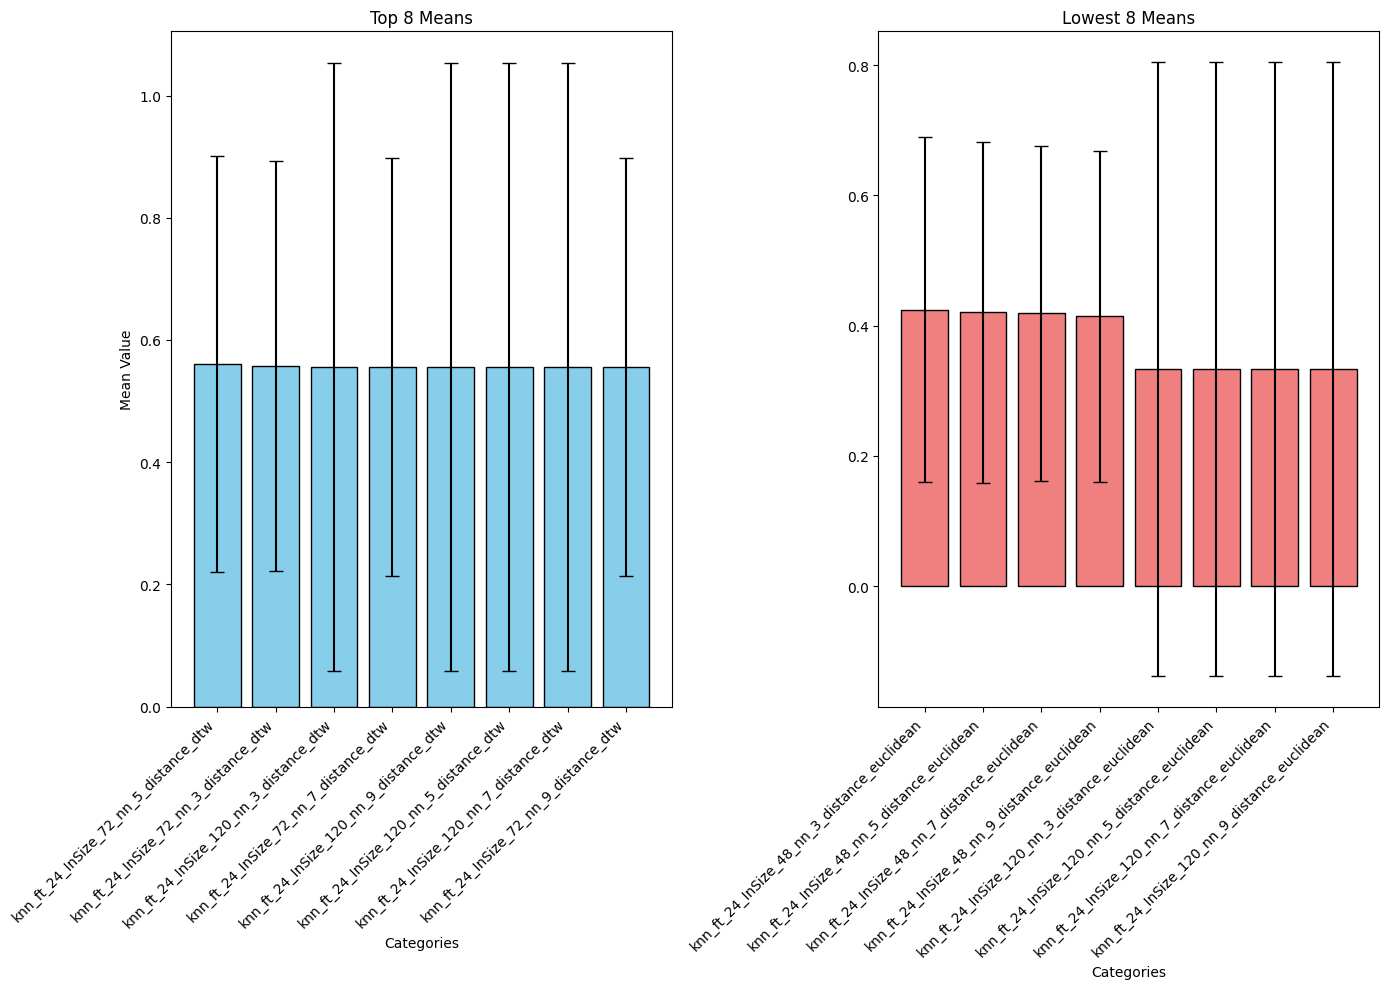

In [ ]:
# Set the size of the figure
fig, axs = plt.subplots(1, 2, figsize=(14, 10))

# Plot the top five means in the left figure
bars_left = axs[0].bar(df_sorted.head(8).index, df_sorted['Mean'].head(8), yerr=df_sorted['Std'].head(8).values.T, capsize=5, color='skyblue', edgecolor='black')
axs[0].set_title('Top 8 Means')
axs[0].set_ylabel('Mean Value')

# Plot the lowest five means in the right figure
bars_right = axs[1].bar(df_sorted.tail(8).index, df_sorted['Mean'].tail(8), yerr=df_sorted['Std'].tail(8).values.T, capsize=5, color='lightcoral', edgecolor='black')
axs[1].set_title('Lowest 8 Means')

# Rotate x-axis labels at 45 degrees for better readability
for ax in axs:
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

# Adding major axis labels to the left figure
axs[0].set_xlabel('Categories')
axs[0].set_ylabel('Mean Value')

# Adding major axis labels to the right figure
axs[1].set_xlabel('Categories')

# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()

# SVM

In [ ]:
# Import necessary libraries
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score
import pandas as pd

import numpy as np

# Specify the hyper-parameters to try
in_sizes = [48, 72, 96, 120]
kernels = ['linear', 'rbf']
Cs = [150, 200, 250, 300]
doScale = True
# Forecast horizon - 24 time steps in the future (one week ahead)
fh = 24



In [ ]:
# Manually keep track of results of temporal CV
scores = []
names = []
sum_confusion_matrices = []
dat = df_loweststd[df_loweststd.columns[0]].copy()
# Grid search over all hyper-parameter combinations
for ins in in_sizes: # number of predictor inputs
    for kernel in kernels: # kernel types
        for C in Cs: # regularization parameter
            cv = list(splitter.split(dat))
            tmp_score = []
            names += [["svc", "ft_" + str(fh),
                       "InSize_" + str(ins),
                       "kernel_" + kernel,
                       "C_" + str(C)]]
            confusion_matrices = []
            for fold in cv: # iterate over the folds of CV
                trn_data = series_to_tabular(dat[fold[0]], n_in=ins, fh=fh)
                trn_data = make_class_labels(trn_data, cls_boundaries, ["Low", "Medium", "High"])
                tst_data = series_to_tabular(dat[fold[1]], n_in=ins, fh=fh)
                tst_data = make_class_labels(tst_data, cls_boundaries, ["Low", "Medium", "High"])

                if doScale:
                    classifier = make_pipeline(StandardScaler(), SVC(kernel=kernel, C=C))
                else:
                    classifier = SVC(kernel=kernel, C=C)

                classifier.fit(trn_data.iloc[:, :ins].values, trn_data['Class'])
                y_pred = classifier.predict(tst_data.iloc[:, :ins].values)
                cm = confusion_matrix(tst_data['Class'], y_pred, labels=["Low", "Medium", "High"])
                confusion_matrices += [cm]
                tmp_score += [accuracy_score(tst_data['Class'], y_pred)]
            scores += [tmp_score]
            sum_confusion_matrices += [sum(confusion_matrices)]

# Calculate mean and standard deviation of scores
res = np.concatenate((np.mean(np.vstack(scores), axis=1).reshape(-1, 1),
                      np.std(np.vstack(scores), axis=1).reshape(-1, 1)), axis=1)
resDf = pd.DataFrame(res)
resDf.columns = ['Mean', 'Std']
namesDf = pd.DataFrame(names)
resDf = pd.concat([namesDf, resDf], axis=1)
resDf


,0,1,2,3,4,Mean,Std
0,svc,ft_24,InSize_48,kernel_linear,C_150,0.631659,0.240362
1,svc,ft_24,InSize_48,kernel_linear,C_200,0.642314,0.245426
2,svc,ft_24,InSize_48,kernel_linear,C_250,0.652968,0.241448
3,svc,ft_24,InSize_48,kernel_linear,C_300,0.656012,0.247288
4,svc,ft_24,InSize_48,kernel_rbf,C_150,0.578387,0.292293
5,svc,ft_24,InSize_48,kernel_rbf,C_200,0.576865,0.295956
6,svc,ft_24,InSize_48,kernel_rbf,C_250,0.590563,0.291197
7,svc,ft_24,InSize_48,kernel_rbf,C_300,0.598174,0.293590
8,svc,ft_24,InSize_72,kernel_linear,C_150,0.546485,0.297113
9,svc,ft_24,InSize_72,kernel_linear,C_200,0.548753,0.300006


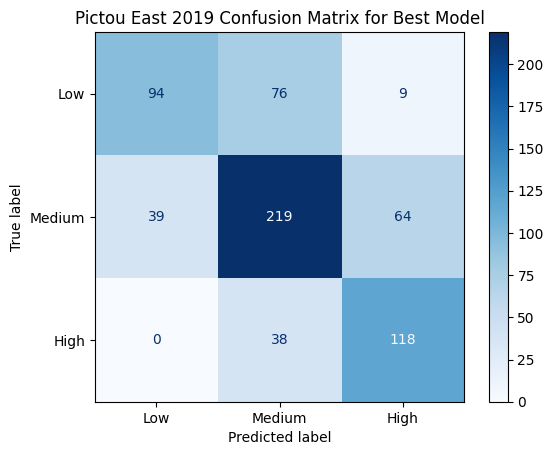

In [ ]:
best_model_idx = np.argmax(np.mean(np.vstack(scores), axis=1))
best_confusion_matrix = sum_confusion_matrices[best_model_idx]

# Create a confusion matrix display for the best model
disp = ConfusionMatrixDisplay(confusion_matrix=best_confusion_matrix, display_labels=["Low", "Medium", "High"])

# Plot the confusion matrix for the best model
disp.plot(cmap='Blues')
plt.title("Pictou East 2019 Confusion Matrix for Best Model")
plt.show()


In [ ]:
resDf['Model_Setup'] = resDf.iloc[:, :5].apply(lambda row: '_'.join(row.astype(str)), axis=1)

# Set the new column as the index if desired
resDf.set_index('Model_Setup', inplace=True)


# Drop the first 5 columns
resDf.drop(resDf.columns[:5], axis=1, inplace=True)

df_sorted = resDf.sort_values(by='Mean', ascending=False)

df_sorted

,Mean,Std
Model_Setup,,
svc_ft_24_InSize_48_kernel_linear_C_300,0.656012,0.247288
svc_ft_24_InSize_48_kernel_linear_C_250,0.652968,0.241448
svc_ft_24_InSize_48_kernel_linear_C_200,0.642314,0.245426
svc_ft_24_InSize_48_kernel_linear_C_150,0.631659,0.240362
svc_ft_24_InSize_48_kernel_rbf_C_300,0.598174,0.293590
svc_ft_24_InSize_48_kernel_rbf_C_250,0.590563,0.291197
svc_ft_24_InSize_48_kernel_rbf_C_150,0.578387,0.292293
svc_ft_24_InSize_48_kernel_rbf_C_200,0.576865,0.295956
svc_ft_24_InSize_72_kernel_linear_C_300,0.566893,0.316568


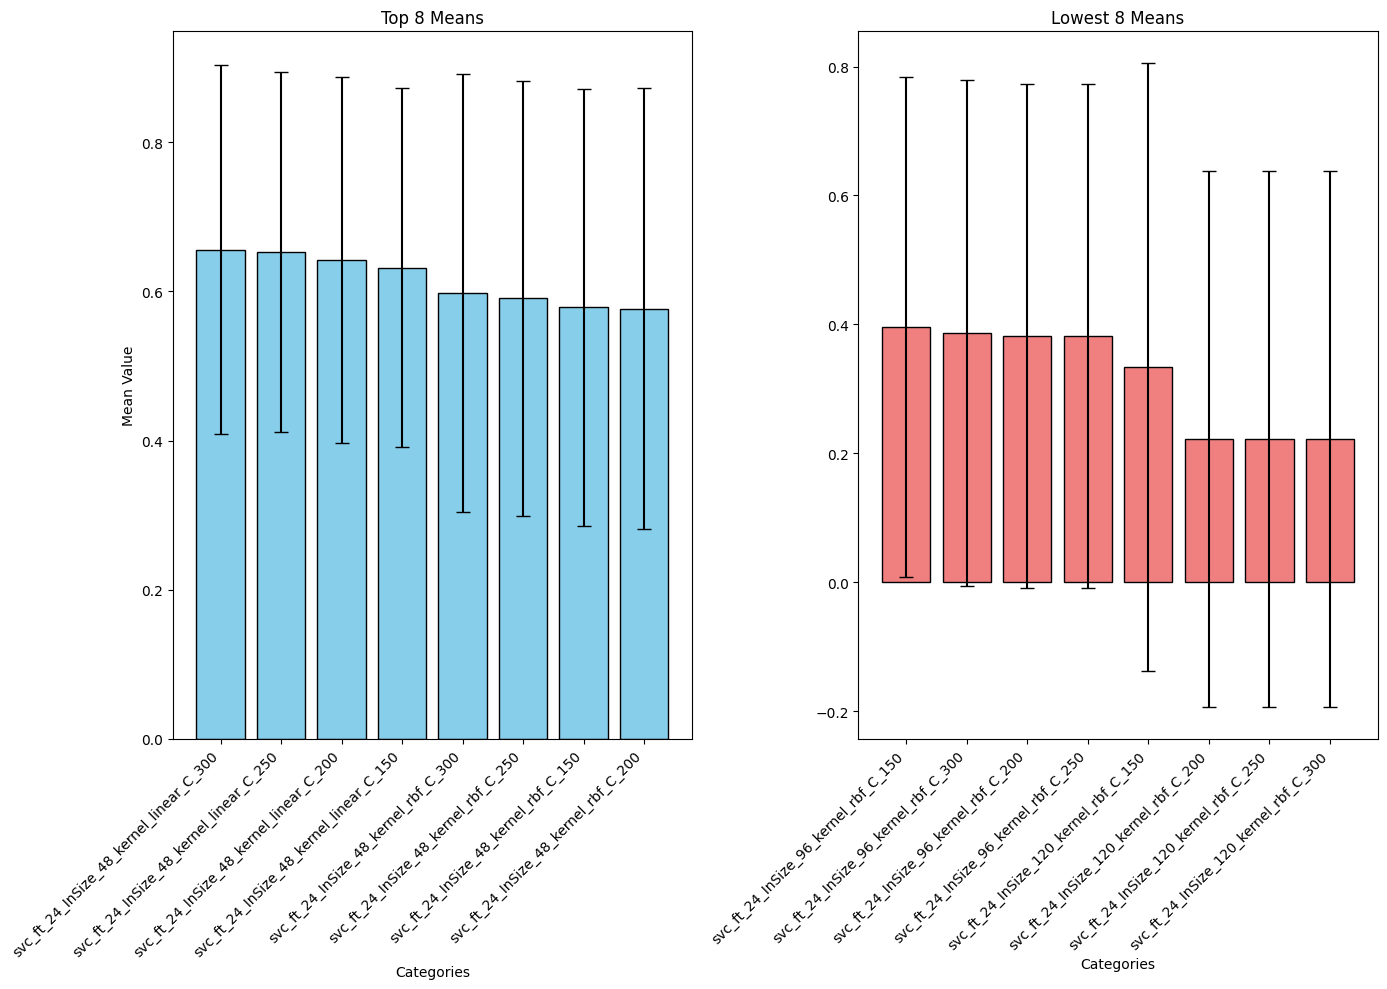

In [ ]:
# Set the size of the figure
fig, axs = plt.subplots(1, 2, figsize=(14, 10))

# Plot the top five means in the left figure
bars_left = axs[0].bar(df_sorted.head(8).index, df_sorted['Mean'].head(8), yerr=df_sorted['Std'].head(8).values.T, capsize=5, color='skyblue', edgecolor='black')
axs[0].set_title('Top 8 Means')
axs[0].set_ylabel('Mean Value')

# Plot the lowest five means in the right figure
bars_right = axs[1].bar(df_sorted.tail(8).index, df_sorted['Mean'].tail(8), yerr=df_sorted['Std'].tail(8).values.T, capsize=5, color='lightcoral', edgecolor='black')
axs[1].set_title('Lowest 8 Means')

# Rotate x-axis labels at 45 degrees for better readability
for ax in axs:
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

# Adding major axis labels to the left figure
axs[0].set_xlabel('Categories')
axs[0].set_ylabel('Mean Value')

# Adding major axis labels to the right figure
axs[1].set_xlabel('Categories')

# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()

# Random Forest Classifier

In [ ]:
# Import necessary libraries
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score
import pandas as pd
import numpy as np

# Specify the hyper-parameters to try
in_sizes = [48, 72, 96, 120]
n_estimators = [50, 75, 100, 125]  # Number of trees in the forest
max_depths = [None, 10, 20, 30] # Maximum depth of each tree
doScale = True
# Forecast horizon - 24 time steps in the future (one week ahead)
fh = 24



In [ ]:
# Manually keep track of results of temporal CV
scores = []
names = []
sum_confusion_matrices = []
dat = df_loweststd[df_loweststd.columns[0]].copy()
# Grid search over all hyper-parameter combinations
for ins in in_sizes: # number of predictor inputs
    for n_estimator in n_estimators: # number of trees
        for max_depth in max_depths: # maximum depth of the tree
            cv = list(splitter.split(dat))
            tmp_score = []
            names += [["rf", "ft_" + str(fh),
                       "InSize_" + str(ins),
                       "n_estimators_" + str(n_estimator),
                       "max_depth_" + str(max_depth if max_depth is not None else 'None')]]
            confusion_matrices = []
            for fold in cv: # iterate over the folds of CV
                trn_data = series_to_tabular(dat[fold[0]], n_in=ins, fh=fh)
                trn_data = make_class_labels(trn_data, cls_boundaries, ["Low", "Medium", "High"])
                tst_data = series_to_tabular(dat[fold[1]], n_in=ins, fh=fh)
                tst_data = make_class_labels(tst_data, cls_boundaries, ["Low", "Medium", "High"])

                if doScale:
                    classifier = make_pipeline(StandardScaler(), RandomForestClassifier(n_estimators=n_estimator, max_depth=max_depth))
                else:
                    classifier = RandomForestClassifier(n_estimators=n_estimator, max_depth=max_depth)

                classifier.fit(trn_data.iloc[:, :ins].values, trn_data['Class'])
                y_pred = classifier.predict(tst_data.iloc[:, :ins].values)
                cm = confusion_matrix(tst_data['Class'], y_pred, labels=["Low", "Medium", "High"])
                confusion_matrices += [cm]
                tmp_score += [accuracy_score(tst_data['Class'], y_pred)]
            scores += [tmp_score]
            sum_confusion_matrices += [sum(confusion_matrices)]

# Calculate mean and standard deviation of scores
res = np.concatenate((np.mean(np.vstack(scores), axis=1).reshape(-1, 1),
                      np.std(np.vstack(scores), axis=1).reshape(-1, 1)), axis=1)
resDf = pd.DataFrame(res)
resDf.columns = ['Mean', 'Std']
namesDf = pd.DataFrame(names)
resDf = pd.concat([namesDf, resDf], axis=1)
resDf


,0,1,2,3,4,Mean,Std
0,rf,ft_24,InSize_48,n_estimators_50,max_depth_None,0.438356,0.280144
1,rf,ft_24,InSize_48,n_estimators_50,max_depth_10,0.445967,0.286554
2,rf,ft_24,InSize_48,n_estimators_50,max_depth_20,0.412481,0.300014
3,rf,ft_24,InSize_48,n_estimators_50,max_depth_30,0.409437,0.304429
4,rf,ft_24,InSize_48,n_estimators_75,max_depth_None,0.415525,0.308211
...,...,...,...,...,...,...,...
59,rf,ft_24,InSize_120,n_estimators_100,max_depth_30,0.333333,0.471405
60,rf,ft_24,InSize_120,n_estimators_125,max_depth_None,0.222222,0.415740
61,rf,ft_24,InSize_120,n_estimators_125,max_depth_10,0.333333,0.471405
62,rf,ft_24,InSize_120,n_estimators_125,max_depth_20,0.222222,0.415740


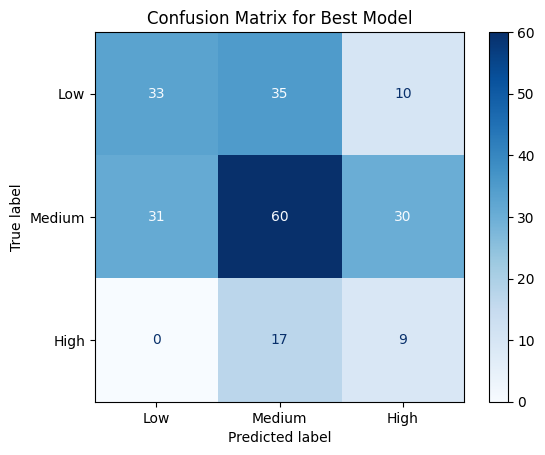

In [ ]:
best_model_idx = np.argmax(np.mean(np.vstack(scores), axis=1))
best_confusion_matrix = sum_confusion_matrices[best_model_idx]

# Create a confusion matrix display for the best model
disp = ConfusionMatrixDisplay(confusion_matrix=best_confusion_matrix, display_labels=["Low", "Medium", "High"])

# Plot the confusion matrix for the best model
disp.plot(cmap='Blues')
plt.title("Confusion Matrix for Best Model")
plt.show()


In [ ]:
resDf['Model_Setup'] = resDf.iloc[:, :5].apply(lambda row: '_'.join(row.astype(str)), axis=1)

# Set the new column as the index if desired
resDf.set_index('Model_Setup', inplace=True)


# Drop the first 5 columns
resDf.drop(resDf.columns[:5], axis=1, inplace=True)

df_sorted = resDf.sort_values(by='Mean', ascending=False)

df_sorted

,Mean,Std
Model_Setup,,
rf_ft_24_InSize_96_n_estimators_75_max_depth_30,0.453333,0.407922
rf_ft_24_InSize_48_n_estimators_50_max_depth_10,0.445967,0.286554
rf_ft_24_InSize_120_n_estimators_100_max_depth_20,0.444444,0.496904
rf_ft_24_InSize_48_n_estimators_100_max_depth_10,0.438356,0.301577
rf_ft_24_InSize_48_n_estimators_50_max_depth_None,0.438356,0.280144
...,...,...
rf_ft_24_InSize_120_n_estimators_100_max_depth_None,0.222222,0.415740
rf_ft_24_InSize_120_n_estimators_100_max_depth_10,0.222222,0.415740
rf_ft_24_InSize_120_n_estimators_125_max_depth_None,0.222222,0.415740


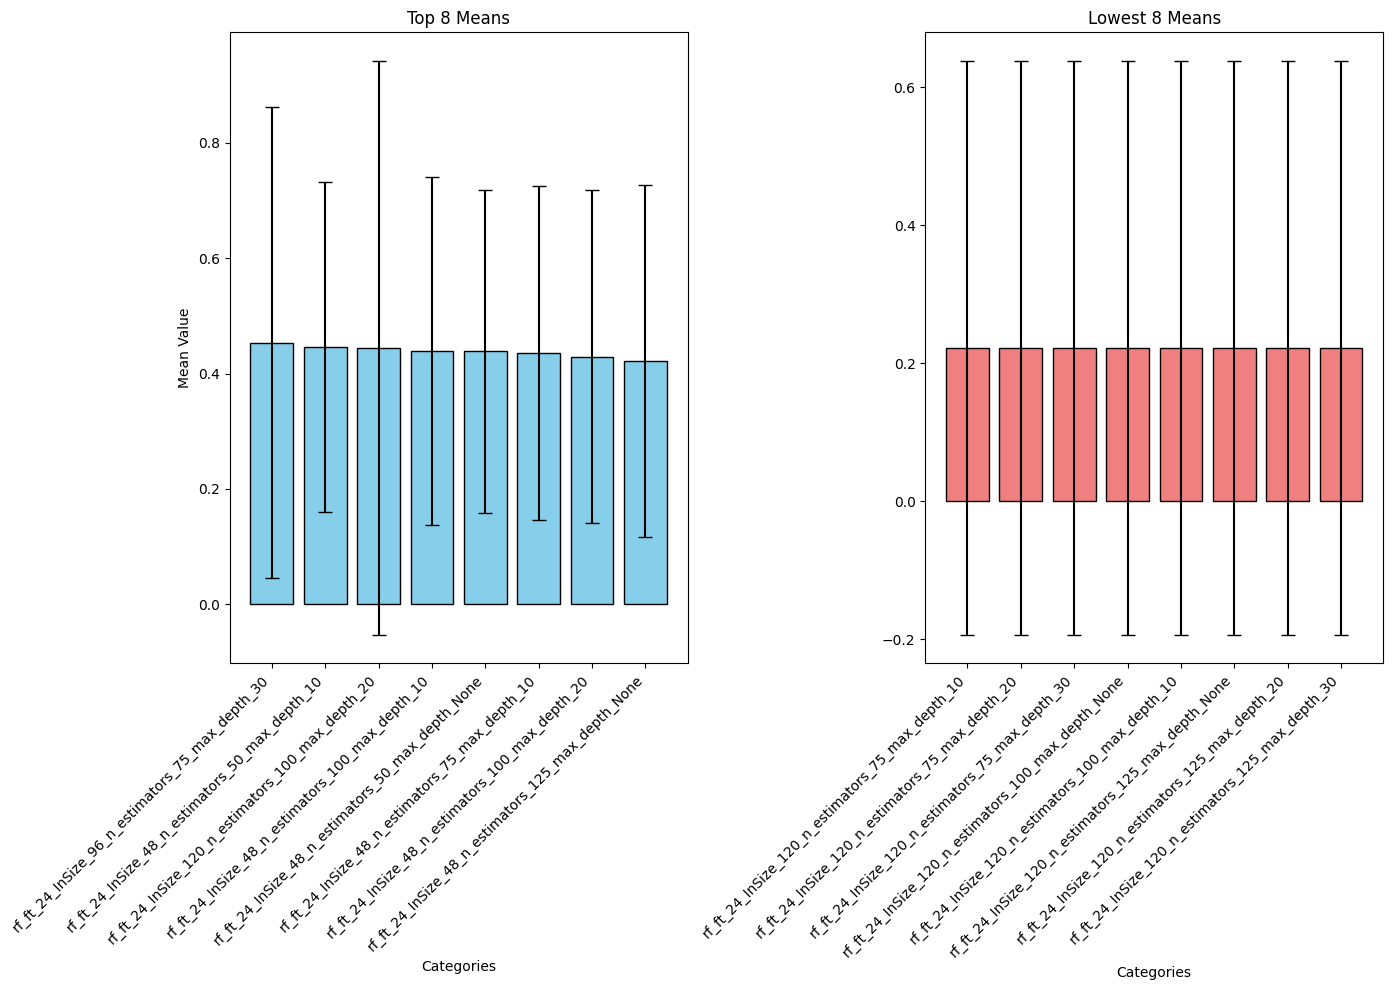

In [ ]:
# Set the size of the figure
fig, axs = plt.subplots(1, 2, figsize=(14, 10))

# Plot the top five means in the left figure
bars_left = axs[0].bar(df_sorted.head(8).index, df_sorted['Mean'].head(8), yerr=df_sorted['Std'].head(8).values.T, capsize=5, color='skyblue', edgecolor='black')
axs[0].set_title('Top 8 Means')
axs[0].set_ylabel('Mean Value')

# Plot the lowest five means in the right figure
bars_right = axs[1].bar(df_sorted.tail(8).index, df_sorted['Mean'].tail(8), yerr=df_sorted['Std'].tail(8).values.T, capsize=5, color='lightcoral', edgecolor='black')
axs[1].set_title('Lowest 8 Means')

# Rotate x-axis labels at 45 degrees for better readability
for ax in axs:
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

# Adding major axis labels to the left figure
axs[0].set_xlabel('Categories')
axs[0].set_ylabel('Mean Value')

# Adding major axis labels to the right figure
axs[1].set_xlabel('Categories')

# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()

# Second Lowest Standard Deviation

# KNN


In [ ]:
# define equal size classes
cls_boundaries = np.quantile(df_secondLoweststd, [.25, .75])
print("We discretize the data into low, medium and high at " + str(cls_boundaries))

We discretize the data into low, medium and high at [8.21710625 8.77010571]


In [ ]:
# Specify the hyper-parameters to try
in_sizes = [48,72,96,120]
n_neighbors =  [5,7,9,11]
distances    =  ["euclidean", "dtw"]
doScale = True
# Forecast horizone - 24 time steps in the future (one week ahead)
fh = 24

In [ ]:
# manually keep track of results of temporal CV
scores = []
names = []
sum_confusion_matrices = []
dat = df_secondLoweststd[df_secondLoweststd.columns[0]].copy()
# Grid search over all hyper-parameter combinations
for ins in in_sizes: # number of predictor inputs
  for nn in n_neighbors: # number of nearest neigbours to use
    for dist in distances: # distance function to use
      cv = list(splitter.split(dat))
      tmp_score = []
      names += [["knn", "ft_" + str(fh),
                 "InSize_" + str(ins),
                 "nn_" + str(nn),
                 "distance_" + dist]]
      confusion_matrices = []
      for fold in cv: #iterate over the folds of CV
        trn_data = series_to_tabular(dat[fold[0]],
                                     n_in=ins,
                                     fh=fh) #tabularize the training data
        trn_data =  make_class_labels(trn_data,
                                      cls_boundaries,
                                       ["Low", "Medium", "High"]) # discretize the training targets
        tst_data = series_to_tabular(dat[fold[1]],
                                     n_in=ins,
                                     fh=fh) # discretize the testing targets
        tst_data =  make_class_labels(tst_data,
                                      cls_boundaries,
                                       ["Low", "Medium", "High"]) #tabularize the testing data

        if doScale:
          #make a pipeline to scale the data and train kNN classifier
          classifier = make_pipeline(StandardScaler(),
                                     KNeighborsTimeSeriesClassifier(n_neighbors=nn,
                                                                    distance=dist))
        else:
          #make a pipeline to scale the data and train kNN classifier
          classifier = make_pipeline(KNeighborsTimeSeriesClassifier(n_neighbors=nn,
                                                                    distance=dist))
        #fit the classifier
        classifier.fit(trn_data.iloc[:,:ins].values, trn_data['Class'])
        #make predictions and calculate test accuracy
        y_pred = classifier.predict(tst_data.iloc[:,:ins].values)
        cm = confusion_matrix(tst_data['Class'], y_pred, labels=["Low", "Medium", "High"])
        confusion_matrices += [cm]

        tmp_score += [accuracy_score(tst_data['Class'], y_pred)]
      scores += [tmp_score]
      sum_confusion_matrices += [sum(confusion_matrices)]

res = np.concatenate((np.mean(np.vstack(scores),axis=1).reshape(-1,1),
                      np.std(np.vstack(scores),axis=1).reshape(-1,1)),axis=1)
resDf = pd.DataFrame(res)
resDf.columns = ['Mean', 'Std']
namesDf = pd.DataFrame(names)
resDf = pd.concat([namesDf, resDf], axis=1)
resDf

,0,1,2,3,4,Mean,Std
0,knn,ft_24,InSize_48,nn_5,distance_euclidean,0.444444,0.341650
1,knn,ft_24,InSize_48,nn_5,distance_dtw,0.421613,0.293005
2,knn,ft_24,InSize_48,nn_7,distance_euclidean,0.445967,0.343415
3,knn,ft_24,InSize_48,nn_7,distance_dtw,0.424658,0.297400
4,knn,ft_24,InSize_48,nn_9,distance_euclidean,0.449011,0.340223
5,knn,ft_24,InSize_48,nn_9,distance_dtw,0.427702,0.301838
6,knn,ft_24,InSize_48,nn_11,distance_euclidean,0.449011,0.347859
7,knn,ft_24,InSize_48,nn_11,distance_dtw,0.423135,0.301331
8,knn,ft_24,InSize_72,nn_5,distance_euclidean,0.453515,0.377508
9,knn,ft_24,InSize_72,nn_5,distance_dtw,0.412698,0.329040


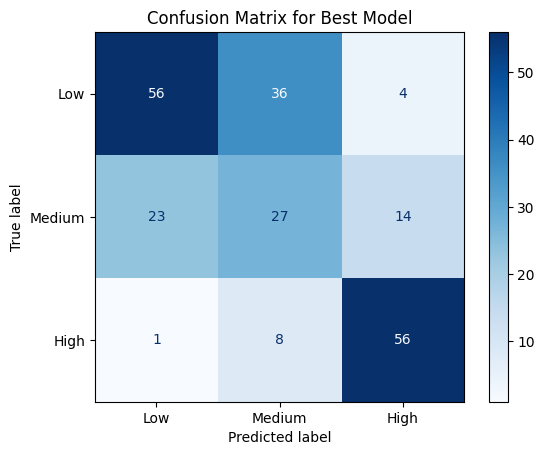

In [ ]:
best_model_idx = np.argmax(np.mean(np.vstack(scores), axis=1))
best_confusion_matrix = sum_confusion_matrices[best_model_idx]

# Create a confusion matrix display for the best model
disp = ConfusionMatrixDisplay(confusion_matrix=best_confusion_matrix, display_labels=["Low", "Medium", "High"])

# Plot the confusion matrix for the best model
disp.plot(cmap='Blues')
plt.title("Confusion Matrix for Best Model")
plt.show()


In [ ]:
resDf['Model_Setup'] = resDf.iloc[:, :5].apply(lambda row: '_'.join(row.astype(str)), axis=1)

# Set the new column as the index if desired
resDf.set_index('Model_Setup', inplace=True)


# Drop the first 5 columns
resDf.drop(resDf.columns[:5], axis=1, inplace=True)

resDf

,Mean,Std
Model_Setup,,
knn_ft_24_InSize_48_nn_5_distance_euclidean,0.444444,0.341650
knn_ft_24_InSize_48_nn_5_distance_dtw,0.421613,0.293005
knn_ft_24_InSize_48_nn_7_distance_euclidean,0.445967,0.343415
knn_ft_24_InSize_48_nn_7_distance_dtw,0.424658,0.297400
knn_ft_24_InSize_48_nn_9_distance_euclidean,0.449011,0.340223
knn_ft_24_InSize_48_nn_9_distance_dtw,0.427702,0.301838
knn_ft_24_InSize_48_nn_11_distance_euclidean,0.449011,0.347859
knn_ft_24_InSize_48_nn_11_distance_dtw,0.423135,0.301331
knn_ft_24_InSize_72_nn_5_distance_euclidean,0.453515,0.377508


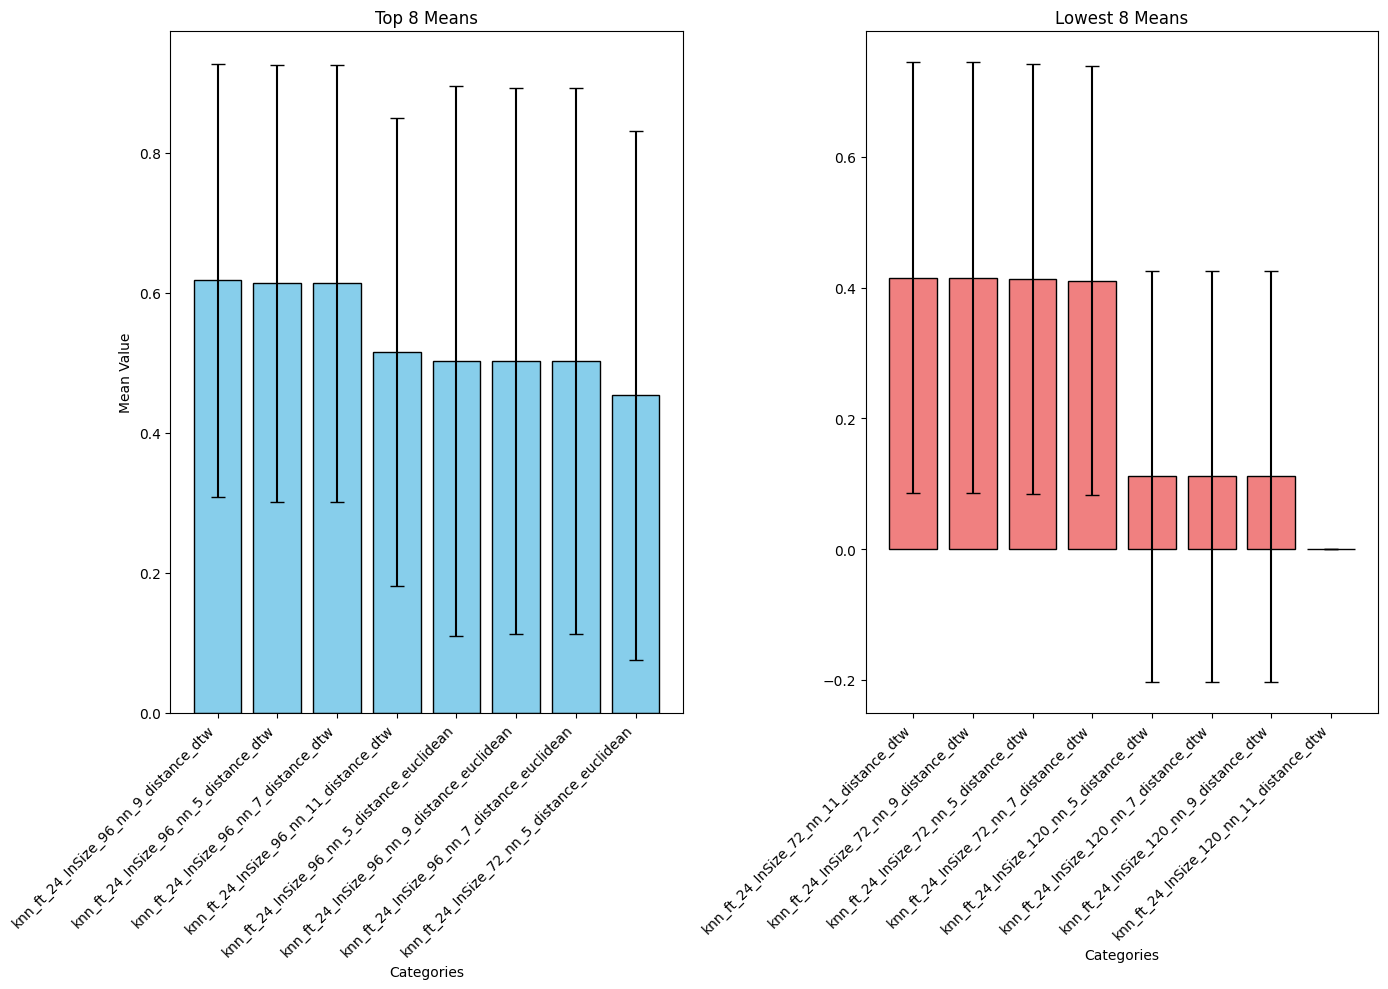

In [ ]:
df_sorted = resDf.sort_values(by='Mean', ascending=False)

# Set the size of the figure
fig, axs = plt.subplots(1, 2, figsize=(14, 10))

# Plot the top five means in the left figure
bars_left = axs[0].bar(df_sorted.head(8).index, df_sorted['Mean'].head(8), yerr=df_sorted['Std'].head(8).values.T, capsize=5, color='skyblue', edgecolor='black')
axs[0].set_title('Top 8 Means')
axs[0].set_ylabel('Mean Value')

# Plot the lowest five means in the right figure
bars_right = axs[1].bar(df_sorted.tail(8).index, df_sorted['Mean'].tail(8), yerr=df_sorted['Std'].tail(8).values.T, capsize=5, color='lightcoral', edgecolor='black')
axs[1].set_title('Lowest 8 Means')

# Rotate x-axis labels at 45 degrees for better readability
for ax in axs:
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

# Adding major axis labels to the left figure
axs[0].set_xlabel('Categories')
axs[0].set_ylabel('Mean Value')

# Adding major axis labels to the right figure
axs[1].set_xlabel('Categories')

# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()

# SVM

In [ ]:
# Import necessary libraries
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score
import pandas as pd
import numpy as np

# Specify the hyper-parameters to try
in_sizes = [48, 72, 96, 120]
kernels = ['linear', 'rbf']
Cs = [200,250,300,350]
doScale = True
# Forecast horizon - 24 time steps in the future (one week ahead)
fh = 24



In [ ]:
# Manually keep track of results of temporal CV
scores = []
names = []
sum_confusion_matrices = []
dat = df_secondLoweststd[df_secondLoweststd.columns[0]].copy()
# Grid search over all hyper-parameter combinations
for ins in in_sizes: # number of predictor inputs
    for kernel in kernels: # kernel types
        for C in Cs: # regularization parameter
            cv = list(splitter.split(dat))
            tmp_score = []
            names += [["svc", "ft_" + str(fh),
                       "InSize_" + str(ins),
                       "kernel_" + kernel,
                       "C_" + str(C)]]
            confusion_matrices = []
            for fold in cv: # iterate over the folds of CV
                trn_data = series_to_tabular(dat[fold[0]], n_in=ins, fh=fh)
                trn_data = make_class_labels(trn_data, cls_boundaries, ["Low", "Medium", "High"])
                tst_data = series_to_tabular(dat[fold[1]], n_in=ins, fh=fh)
                tst_data = make_class_labels(tst_data, cls_boundaries, ["Low", "Medium", "High"])

                if doScale:
                    classifier = make_pipeline(StandardScaler(), SVC(kernel=kernel, C=C))
                else:
                    classifier = SVC(kernel=kernel, C=C)

                classifier.fit(trn_data.iloc[:, :ins].values, trn_data['Class'])
                y_pred = classifier.predict(tst_data.iloc[:, :ins].values)
                cm = confusion_matrix(tst_data['Class'], y_pred, labels=["Low", "Medium", "High"])
                confusion_matrices += [cm]
                tmp_score += [accuracy_score(tst_data['Class'], y_pred)]
            scores += [tmp_score]
            sum_confusion_matrices += [sum(confusion_matrices)]

# Calculate mean and standard deviation of scores
res = np.concatenate((np.mean(np.vstack(scores), axis=1).reshape(-1, 1),
                      np.std(np.vstack(scores), axis=1).reshape(-1, 1)), axis=1)
resDf = pd.DataFrame(res)
resDf.columns = ['Mean', 'Std']
namesDf = pd.DataFrame(names)
resDf = pd.concat([namesDf, resDf], axis=1)
resDf


,0,1,2,3,4,Mean,Std
0,svc,ft_24,InSize_48,kernel_linear,C_200,0.745814,0.241803
1,svc,ft_24,InSize_48,kernel_linear,C_250,0.750381,0.228016
2,svc,ft_24,InSize_48,kernel_linear,C_300,0.764079,0.209825
3,svc,ft_24,InSize_48,kernel_linear,C_350,0.767123,0.209847
4,svc,ft_24,InSize_48,kernel_rbf,C_200,0.505327,0.332265
5,svc,ft_24,InSize_48,kernel_rbf,C_250,0.506849,0.335671
6,svc,ft_24,InSize_48,kernel_rbf,C_300,0.499239,0.335988
7,svc,ft_24,InSize_48,kernel_rbf,C_350,0.496195,0.337021
8,svc,ft_24,InSize_72,kernel_linear,C_200,0.746032,0.195538
9,svc,ft_24,InSize_72,kernel_linear,C_250,0.746032,0.194589


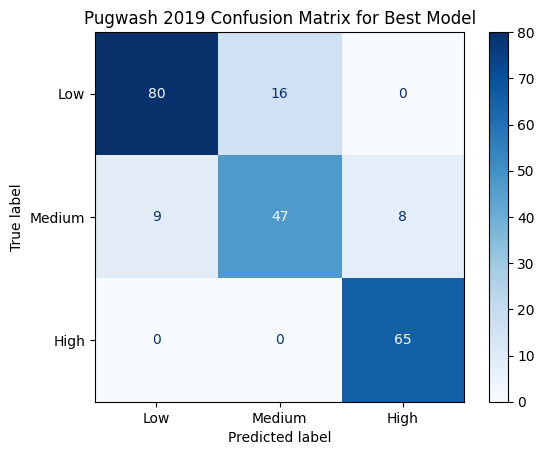

In [ ]:
best_model_idx = np.argmax(np.mean(np.vstack(scores), axis=1))
best_confusion_matrix = sum_confusion_matrices[best_model_idx]

# Create a confusion matrix display for the best model
disp = ConfusionMatrixDisplay(confusion_matrix=best_confusion_matrix, display_labels=["Low", "Medium", "High"])

# Plot the confusion matrix for the best model
disp.plot(cmap='Blues')
plt.title("Pugwash 2019 Confusion Matrix for Best Model")
plt.show()


In [ ]:
resDf['Model_Setup'] = resDf.iloc[:, :5].apply(lambda row: '_'.join(row.astype(str)), axis=1)

# Set the new column as the index if desired
resDf.set_index('Model_Setup', inplace=True)


# Drop the first 5 columns
resDf.drop(resDf.columns[:5], axis=1, inplace=True)

df_sorted = resDf.sort_values(by='Mean', ascending=False)

df_sorted

,Mean,Std
Model_Setup,,
svc_ft_24_InSize_96_kernel_linear_C_200,0.853333,0.173845
svc_ft_24_InSize_96_kernel_linear_C_250,0.848889,0.178664
svc_ft_24_InSize_96_kernel_linear_C_350,0.844444,0.186137
svc_ft_24_InSize_96_kernel_linear_C_300,0.840000,0.191369
svc_ft_24_InSize_48_kernel_linear_C_350,0.767123,0.209847
svc_ft_24_InSize_48_kernel_linear_C_300,0.764079,0.209825
svc_ft_24_InSize_48_kernel_linear_C_250,0.750381,0.228016
svc_ft_24_InSize_72_kernel_linear_C_250,0.746032,0.194589
svc_ft_24_InSize_72_kernel_linear_C_300,0.746032,0.196011


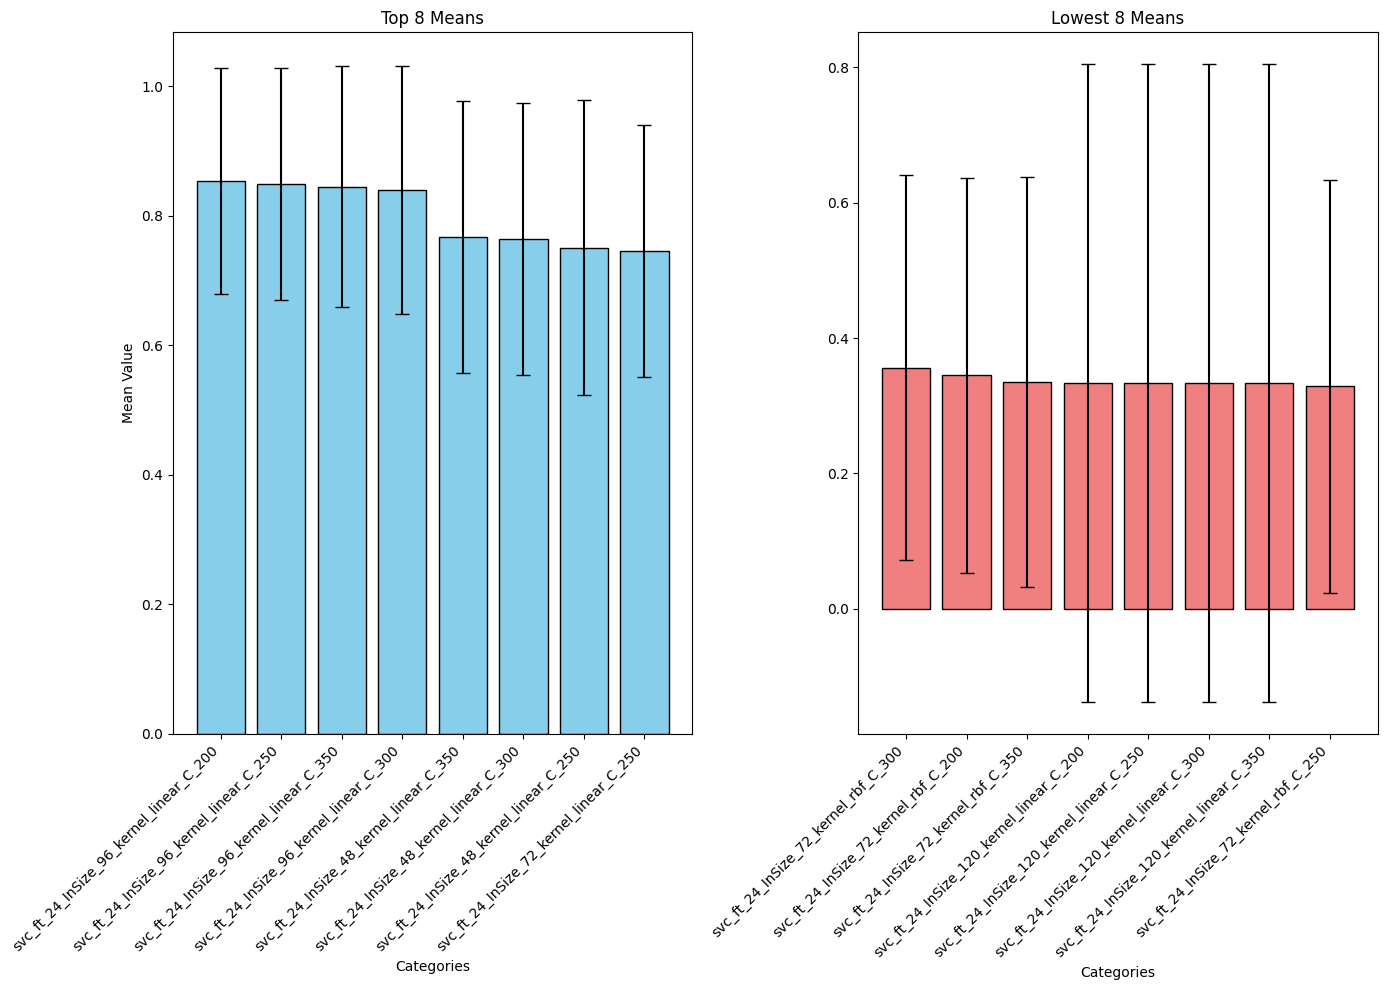

In [ ]:

# Set the size of the figure
fig, axs = plt.subplots(1, 2, figsize=(14, 10))

# Plot the top five means in the left figure
bars_left = axs[0].bar(df_sorted.head(8).index, df_sorted['Mean'].head(8), yerr=df_sorted['Std'].head(8).values.T, capsize=5, color='skyblue', edgecolor='black')
axs[0].set_title('Top 8 Means')
axs[0].set_ylabel('Mean Value')

# Plot the lowest five means in the right figure
bars_right = axs[1].bar(df_sorted.tail(8).index, df_sorted['Mean'].tail(8), yerr=df_sorted['Std'].tail(8).values.T, capsize=5, color='lightcoral', edgecolor='black')
axs[1].set_title('Lowest 8 Means')

# Rotate x-axis labels at 45 degrees for better readability
for ax in axs:
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

# Adding major axis labels to the left figure
axs[0].set_xlabel('Categories')
axs[0].set_ylabel('Mean Value')

# Adding major axis labels to the right figure
axs[1].set_xlabel('Categories')

# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()

# Random Forest Classifier

In [ ]:
# Import necessary libraries
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score
import pandas as pd
import numpy as np

# Specify the hyper-parameters to try
in_sizes = [48, 72, 96, 120]
n_estimators = [250, 300, 350, 400]  # Number of trees in the forest
max_depths = [25, 30, 35, 40] # Maximum depth of each tree
doScale = True
# Forecast horizon - 24 time steps in the future (one week ahead)
fh = 24



In [ ]:
# Manually keep track of results of temporal CV
scores = []
names = []
sum_confusion_matrices = []
dat = df_secondLoweststd[df_secondLoweststd.columns[0]].copy()
# Grid search over all hyper-parameter combinations
for ins in in_sizes: # number of predictor inputs
    for n_estimator in n_estimators: # number of trees
        for max_depth in max_depths: # maximum depth of the tree
            cv = list(splitter.split(dat))
            tmp_score = []
            names += [["rf", "ft_" + str(fh),
                       "InSize_" + str(ins),
                       "n_estimators_" + str(n_estimator),
                       "max_depth_" + str(max_depth if max_depth is not None else 'None')]]
            confusion_matrices = []
            for fold in cv: # iterate over the folds of CV
                trn_data = series_to_tabular(dat[fold[0]], n_in=ins, fh=fh)
                trn_data = make_class_labels(trn_data, cls_boundaries, ["Low", "Medium", "High"])
                tst_data = series_to_tabular(dat[fold[1]], n_in=ins, fh=fh)
                tst_data = make_class_labels(tst_data, cls_boundaries, ["Low", "Medium", "High"])

                if doScale:
                    classifier = make_pipeline(StandardScaler(), RandomForestClassifier(n_estimators=n_estimator, max_depth=max_depth))
                else:
                    classifier = RandomForestClassifier(n_estimators=n_estimator, max_depth=max_depth)

                classifier.fit(trn_data.iloc[:, :ins].values, trn_data['Class'])
                y_pred = classifier.predict(tst_data.iloc[:, :ins].values)
                cm = confusion_matrix(tst_data['Class'], y_pred, labels=["Low", "Medium", "High"])
                confusion_matrices += [cm]
                tmp_score += [accuracy_score(tst_data['Class'], y_pred)]
            scores += [tmp_score]
            sum_confusion_matrices += [sum(confusion_matrices)]

# Calculate mean and standard deviation of scores
res = np.concatenate((np.mean(np.vstack(scores), axis=1).reshape(-1, 1),
                      np.std(np.vstack(scores), axis=1).reshape(-1, 1)), axis=1)
resDf = pd.DataFrame(res)
resDf.columns = ['Mean', 'Std']
namesDf = pd.DataFrame(names)
resDf = pd.concat([namesDf, resDf], axis=1)
resDf


,0,1,2,3,4,Mean,Std
0,rf,ft_24,InSize_48,n_estimators_250,max_depth_25,0.455099,0.304315
1,rf,ft_24,InSize_48,n_estimators_250,max_depth_30,0.455099,0.302804
2,rf,ft_24,InSize_48,n_estimators_250,max_depth_35,0.441400,0.293787
3,rf,ft_24,InSize_48,n_estimators_250,max_depth_40,0.438356,0.295431
4,rf,ft_24,InSize_48,n_estimators_300,max_depth_25,0.442922,0.299217
...,...,...,...,...,...,...,...
59,rf,ft_24,InSize_120,n_estimators_350,max_depth_40,0.555556,0.496904
60,rf,ft_24,InSize_120,n_estimators_400,max_depth_25,0.555556,0.496904
61,rf,ft_24,InSize_120,n_estimators_400,max_depth_30,0.555556,0.496904
62,rf,ft_24,InSize_120,n_estimators_400,max_depth_35,0.666667,0.471405


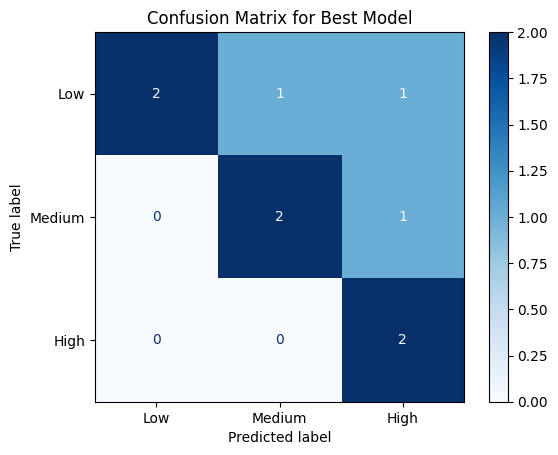

In [ ]:
best_model_idx = np.argmax(np.mean(np.vstack(scores), axis=1))
best_confusion_matrix = sum_confusion_matrices[best_model_idx]

# Create a confusion matrix display for the best model
disp = ConfusionMatrixDisplay(confusion_matrix=best_confusion_matrix, display_labels=["Low", "Medium", "High"])

# Plot the confusion matrix for the best model
disp.plot(cmap='Blues')
plt.title("Confusion Matrix for Best Model")
plt.show()


In [ ]:
resDf['Model_Setup'] = resDf.iloc[:, :5].apply(lambda row: '_'.join(row.astype(str)), axis=1)

# Set the new column as the index if desired
resDf.set_index('Model_Setup', inplace=True)


# Drop the first 5 columns
resDf.drop(resDf.columns[:5], axis=1, inplace=True)

df_sorted = resDf.sort_values(by='Mean', ascending=False)

df_sorted

,Mean,Std
Model_Setup,,
rf_ft_24_InSize_120_n_estimators_400_max_depth_35,0.666667,0.471405
rf_ft_24_InSize_120_n_estimators_400_max_depth_40,0.555556,0.496904
rf_ft_24_InSize_120_n_estimators_300_max_depth_40,0.555556,0.496904
rf_ft_24_InSize_120_n_estimators_250_max_depth_25,0.555556,0.496904
rf_ft_24_InSize_120_n_estimators_250_max_depth_30,0.555556,0.496904
...,...,...
rf_ft_24_InSize_72_n_estimators_400_max_depth_30,0.360544,0.294173
rf_ft_24_InSize_72_n_estimators_400_max_depth_35,0.360544,0.289895
rf_ft_24_InSize_72_n_estimators_300_max_depth_40,0.360544,0.294645


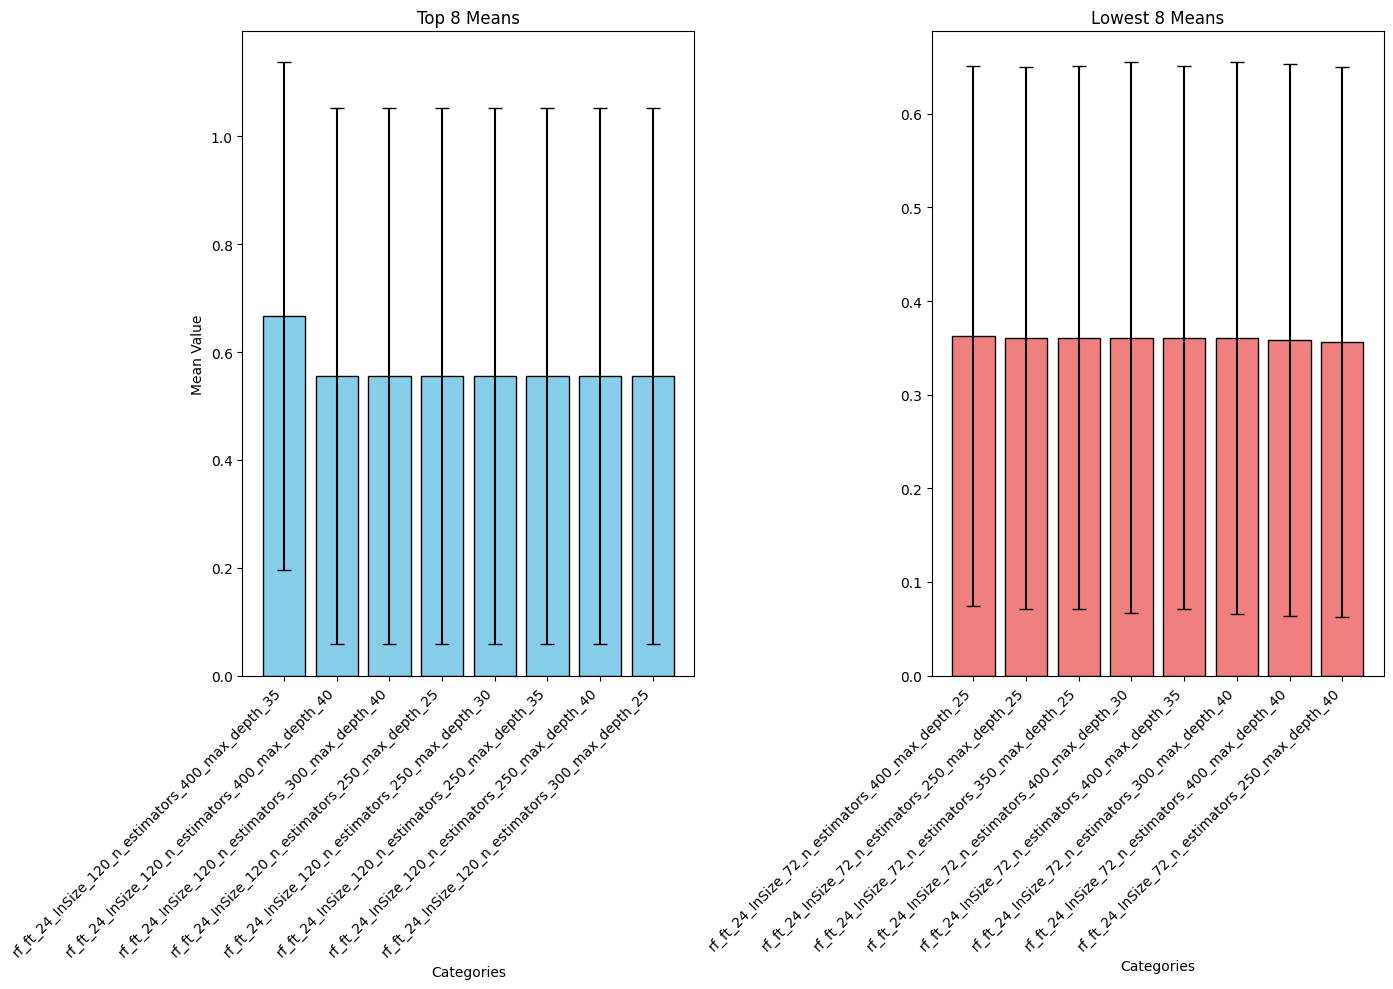

In [ ]:
# Set the size of the figure
fig, axs = plt.subplots(1, 2, figsize=(14, 10))

# Plot the top five means in the left figure
bars_left = axs[0].bar(df_sorted.head(8).index, df_sorted['Mean'].head(8), yerr=df_sorted['Std'].head(8).values.T, capsize=5, color='skyblue', edgecolor='black')
axs[0].set_title('Top 8 Means')
axs[0].set_ylabel('Mean Value')

# Plot the lowest five means in the right figure
bars_right = axs[1].bar(df_sorted.tail(8).index, df_sorted['Mean'].tail(8), yerr=df_sorted['Std'].tail(8).values.T, capsize=5, color='lightcoral', edgecolor='black')
axs[1].set_title('Lowest 8 Means')

# Rotate x-axis labels at 45 degrees for better readability
for ax in axs:
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

# Adding major axis labels to the left figure
axs[0].set_xlabel('Categories')
axs[0].set_ylabel('Mean Value')

# Adding major axis labels to the right figure
axs[1].set_xlabel('Categories')

# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()

# Second Highest STD

# KNN

In [ ]:
# define equal size classes
cls_boundaries = np.quantile(df_secondHigheststd, [.25, .75])
print("We discretize the data into low, medium and high at " + str(cls_boundaries))

We discretize the data into low, medium and high at [ 1.20174856 12.95611285]


In [ ]:
# Specify the hyper-parameters to try
in_sizes = [48,72,96,120]
n_neighbors =  [3,5,7,9]
distances    =  ["euclidean", "dtw"]
doScale = True
# Forecast horizone - 24 time steps in the future (one week ahead)
fh = 24

In [ ]:
# manually keep track of results of temporal CV
scores = []
names = []
sum_confusion_matrices = []
dat = df_secondHigheststd[df_secondHigheststd.columns[0]].copy()
# Grid search over all hyper-parameter combinations
for ins in in_sizes: # number of predictor inputs
  for nn in n_neighbors: # number of nearest neigbours to use
    for dist in distances: # distance function to use
      cv = list(splitter.split(dat))
      tmp_score = []
      names += [["knn", "ft_" + str(fh),
                 "InSize_" + str(ins),
                 "nn_" + str(nn),
                 "distance_" + dist]]
      confusion_matrices = []
      for fold in cv: #iterate over the folds of CV
        trn_data = series_to_tabular(dat[fold[0]],
                                     n_in=ins,
                                     fh=fh) #tabularize the training data
        trn_data =  make_class_labels(trn_data,
                                      cls_boundaries,
                                       ["Low", "Medium", "High"]) # discretize the training targets
        tst_data = series_to_tabular(dat[fold[1]],
                                     n_in=ins,
                                     fh=fh) # discretize the testing targets
        tst_data =  make_class_labels(tst_data,
                                      cls_boundaries,
                                       ["Low", "Medium", "High"]) #tabularize the testing data

        if doScale:
          #make a pipeline to scale the data and train kNN classifier
          classifier = make_pipeline(StandardScaler(),
                                     KNeighborsTimeSeriesClassifier(n_neighbors=nn,
                                                                    distance=dist))
        else:
          #make a pipeline to scale the data and train kNN classifier
          classifier = make_pipeline(KNeighborsTimeSeriesClassifier(n_neighbors=nn,
                                                                    distance=dist))
        #fit the classifier
        classifier.fit(trn_data.iloc[:,:ins].values, trn_data['Class'])
        #make predictions and calculate test accuracy
        y_pred = classifier.predict(tst_data.iloc[:,:ins].values)
        cm = confusion_matrix(tst_data['Class'], y_pred, labels=["Low", "Medium", "High"])
        confusion_matrices += [cm]

        tmp_score += [accuracy_score(tst_data['Class'], y_pred)]
      scores += [tmp_score]
      sum_confusion_matrices += [sum(confusion_matrices)]

res = np.concatenate((np.mean(np.vstack(scores),axis=1).reshape(-1,1),
                      np.std(np.vstack(scores),axis=1).reshape(-1,1)),axis=1)
resDf = pd.DataFrame(res)
resDf.columns = ['Mean', 'Std']
namesDf = pd.DataFrame(names)
resDf = pd.concat([namesDf, resDf], axis=1)
resDf

,0,1,2,3,4,Mean,Std
0,knn,ft_24,InSize_48,nn_3,distance_euclidean,0.480974,0.326951
1,knn,ft_24,InSize_48,nn_3,distance_dtw,0.509893,0.321247
2,knn,ft_24,InSize_48,nn_5,distance_euclidean,0.480974,0.326951
3,knn,ft_24,InSize_48,nn_5,distance_dtw,0.508371,0.319729
4,knn,ft_24,InSize_48,nn_7,distance_euclidean,0.484018,0.328386
5,knn,ft_24,InSize_48,nn_7,distance_dtw,0.506849,0.318131
6,knn,ft_24,InSize_48,nn_9,distance_euclidean,0.484018,0.326157
7,knn,ft_24,InSize_48,nn_9,distance_dtw,0.497717,0.309493
8,knn,ft_24,InSize_72,nn_3,distance_euclidean,0.512472,0.340468
9,knn,ft_24,InSize_72,nn_3,distance_dtw,0.519274,0.325979


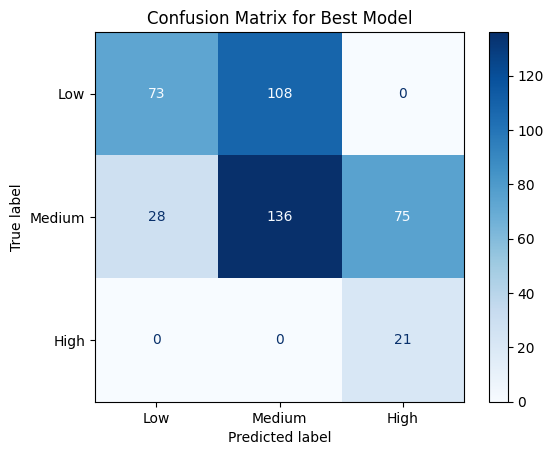

In [ ]:
best_model_idx = np.argmax(np.mean(np.vstack(scores), axis=1))
best_confusion_matrix = sum_confusion_matrices[best_model_idx]

# Create a confusion matrix display for the best model
disp = ConfusionMatrixDisplay(confusion_matrix=best_confusion_matrix, display_labels=["Low", "Medium", "High"])

# Plot the confusion matrix for the best model
disp.plot(cmap='Blues')
plt.title("Confusion Matrix for Best Model")
plt.show()


In [ ]:
resDf['Model_Setup'] = resDf.iloc[:, :5].apply(lambda row: '_'.join(row.astype(str)), axis=1)

# Set the new column as the index if desired
resDf.set_index('Model_Setup', inplace=True)


# Drop the first 5 columns
resDf.drop(resDf.columns[:5], axis=1, inplace=True)

df_sorted = resDf.sort_values(by='Mean', ascending=False)

df_sorted

,Mean,Std
Model_Setup,,
knn_ft_24_InSize_72_nn_5_distance_dtw,0.521542,0.324128
knn_ft_24_InSize_72_nn_3_distance_dtw,0.519274,0.325979
knn_ft_24_InSize_72_nn_3_distance_euclidean,0.512472,0.340468
knn_ft_24_InSize_72_nn_5_distance_euclidean,0.512472,0.340468
knn_ft_24_InSize_72_nn_9_distance_euclidean,0.510204,0.338363
knn_ft_24_InSize_72_nn_7_distance_euclidean,0.510204,0.338363
knn_ft_24_InSize_48_nn_3_distance_dtw,0.509893,0.321247
knn_ft_24_InSize_48_nn_5_distance_dtw,0.508371,0.319729
knn_ft_24_InSize_48_nn_7_distance_dtw,0.506849,0.318131


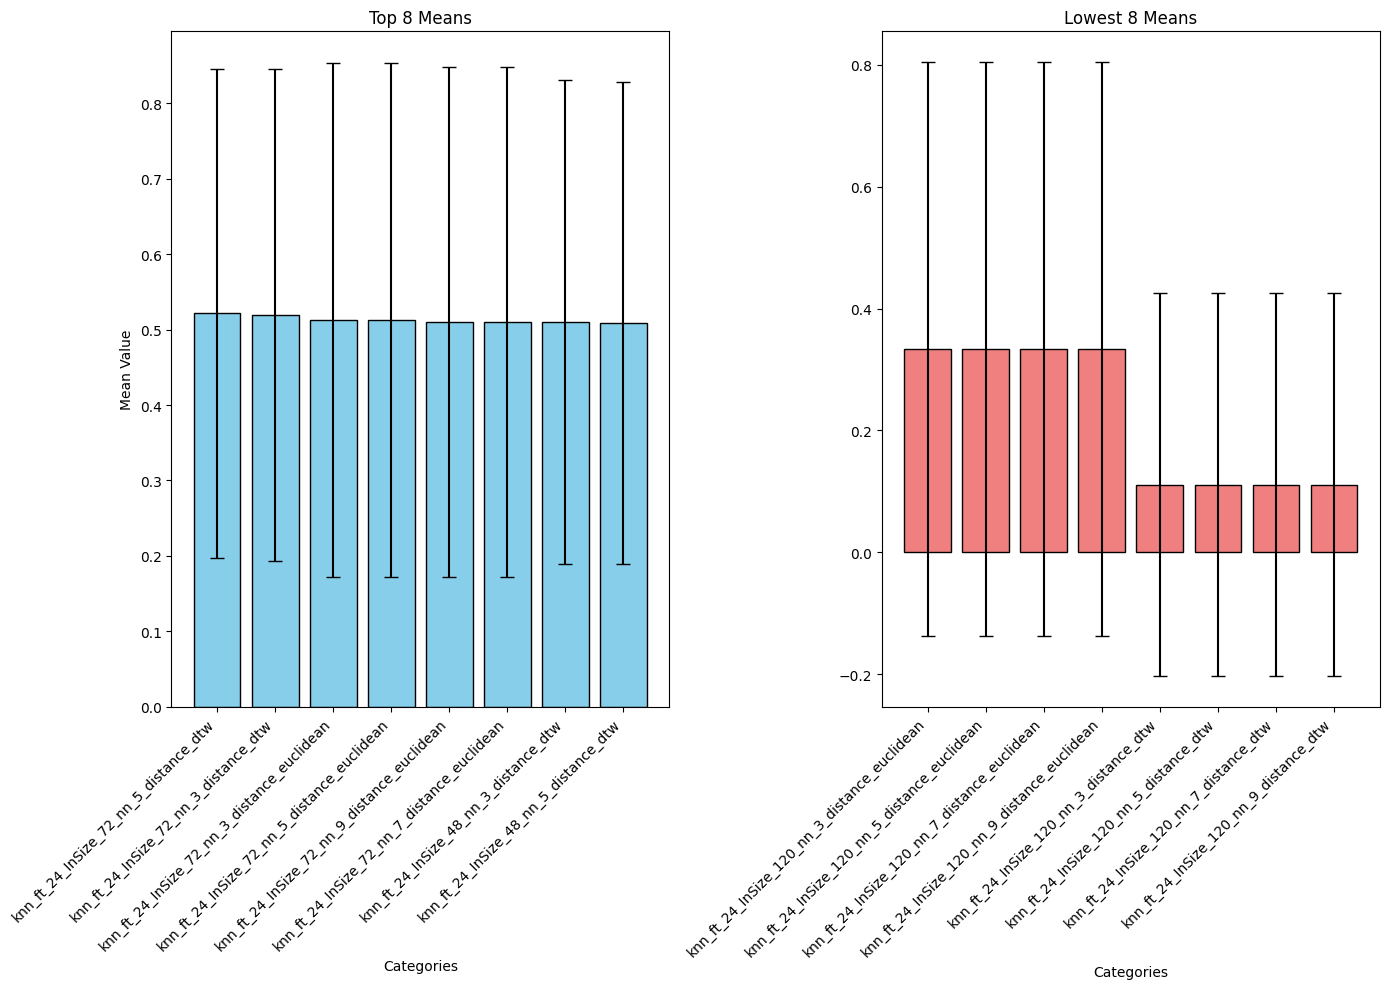

In [ ]:
# Set the size of the figure
fig, axs = plt.subplots(1, 2, figsize=(14, 10))

# Plot the top five means in the left figure
bars_left = axs[0].bar(df_sorted.head(8).index, df_sorted['Mean'].head(8), yerr=df_sorted['Std'].head(8).values.T, capsize=5, color='skyblue', edgecolor='black')
axs[0].set_title('Top 8 Means')
axs[0].set_ylabel('Mean Value')

# Plot the lowest five means in the right figure
bars_right = axs[1].bar(df_sorted.tail(8).index, df_sorted['Mean'].tail(8), yerr=df_sorted['Std'].tail(8).values.T, capsize=5, color='lightcoral', edgecolor='black')
axs[1].set_title('Lowest 8 Means')

# Rotate x-axis labels at 45 degrees for better readability
for ax in axs:
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

# Adding major axis labels to the left figure
axs[0].set_xlabel('Categories')
axs[0].set_ylabel('Mean Value')

# Adding major axis labels to the right figure
axs[1].set_xlabel('Categories')

# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()

# SVM

In [ ]:
# Import necessary libraries
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score
import pandas as pd
import numpy as np

# Specify the hyper-parameters to try
in_sizes = [48, 72, 96, 120]
kernels = ['linear', 'rbf']
Cs = [50, 75, 100,150]
doScale = True
# Forecast horizon - 24 time steps in the future (one week ahead)
fh = 24



In [ ]:
# Manually keep track of results of temporal CV
scores = []
names = []
sum_confusion_matrices = []
dat = df_secondHigheststd[df_secondHigheststd.columns[0]].copy()
# Grid search over all hyper-parameter combinations
for ins in in_sizes: # number of predictor inputs
    for kernel in kernels: # kernel types
        for C in Cs: # regularization parameter
            cv = list(splitter.split(dat))
            tmp_score = []
            names += [["svc", "ft_" + str(fh),
                       "InSize_" + str(ins),
                       "kernel_" + kernel,
                       "C_" + str(C)]]
            confusion_matrices = []
            for fold in cv: # iterate over the folds of CV
                trn_data = series_to_tabular(dat[fold[0]], n_in=ins, fh=fh)
                trn_data = make_class_labels(trn_data, cls_boundaries, ["Low", "Medium", "High"])
                tst_data = series_to_tabular(dat[fold[1]], n_in=ins, fh=fh)
                tst_data = make_class_labels(tst_data, cls_boundaries, ["Low", "Medium", "High"])

                if doScale:
                    classifier = make_pipeline(StandardScaler(), SVC(kernel=kernel, C=C))
                else:
                    classifier = SVC(kernel=kernel, C=C)

                classifier.fit(trn_data.iloc[:, :ins].values, trn_data['Class'])
                y_pred = classifier.predict(tst_data.iloc[:, :ins].values)
                cm = confusion_matrix(tst_data['Class'], y_pred, labels=["Low", "Medium", "High"])
                confusion_matrices += [cm]
                tmp_score += [accuracy_score(tst_data['Class'], y_pred)]
            scores += [tmp_score]
            sum_confusion_matrices += [sum(confusion_matrices)]

# Calculate mean and standard deviation of scores
res = np.concatenate((np.mean(np.vstack(scores), axis=1).reshape(-1, 1),
                      np.std(np.vstack(scores), axis=1).reshape(-1, 1)), axis=1)
resDf = pd.DataFrame(res)
resDf.columns = ['Mean', 'Std']
namesDf = pd.DataFrame(names)
resDf = pd.concat([namesDf, resDf], axis=1)
resDf


,0,1,2,3,4,Mean,Std
0,svc,ft_24,InSize_48,kernel_linear,C_50,0.662100,0.382527
1,svc,ft_24,InSize_48,kernel_linear,C_75,0.663623,0.382588
2,svc,ft_24,InSize_48,kernel_linear,C_100,0.665145,0.382697
3,svc,ft_24,InSize_48,kernel_linear,C_150,0.666667,0.383670
4,svc,ft_24,InSize_48,kernel_rbf,C_50,0.502283,0.301646
5,svc,ft_24,InSize_48,kernel_rbf,C_75,0.491629,0.299805
6,svc,ft_24,InSize_48,kernel_rbf,C_100,0.494673,0.307767
7,svc,ft_24,InSize_48,kernel_rbf,C_150,0.484018,0.308549
8,svc,ft_24,InSize_72,kernel_linear,C_50,0.668934,0.368325
9,svc,ft_24,InSize_72,kernel_linear,C_75,0.673469,0.369106


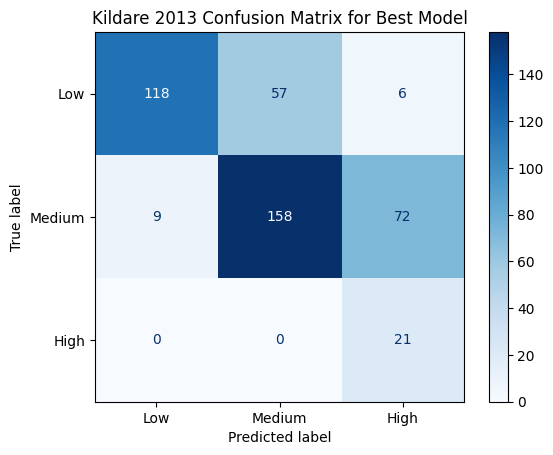

In [ ]:
best_model_idx = np.argmax(np.mean(np.vstack(scores), axis=1))
best_confusion_matrix = sum_confusion_matrices[best_model_idx]

# Create a confusion matrix display for the best model
disp = ConfusionMatrixDisplay(confusion_matrix=best_confusion_matrix, display_labels=["Low", "Medium", "High"])

# Plot the confusion matrix for the best model
disp.plot(cmap='Blues')
plt.title("Kildare 2013 Confusion Matrix for Best Model")
plt.show()


In [ ]:
resDf['Model_Setup'] = resDf.iloc[:, :5].apply(lambda row: '_'.join(row.astype(str)), axis=1)

# Set the new column as the index if desired
resDf.set_index('Model_Setup', inplace=True)


# Drop the first 5 columns
resDf.drop(resDf.columns[:5], axis=1, inplace=True)

df_sorted = resDf.sort_values(by='Mean', ascending=False)

df_sorted

,Mean,Std
Model_Setup,,
svc_ft_24_InSize_72_kernel_linear_C_75,0.673469,0.369106
svc_ft_24_InSize_72_kernel_linear_C_100,0.673469,0.369106
svc_ft_24_InSize_72_kernel_linear_C_150,0.671202,0.367906
svc_ft_24_InSize_72_kernel_linear_C_50,0.668934,0.368325
svc_ft_24_InSize_48_kernel_linear_C_150,0.666667,0.383670
svc_ft_24_InSize_120_kernel_linear_C_150,0.666667,0.471405
svc_ft_24_InSize_120_kernel_linear_C_100,0.666667,0.471405
svc_ft_24_InSize_120_kernel_linear_C_75,0.666667,0.471405
svc_ft_24_InSize_120_kernel_linear_C_50,0.666667,0.471405


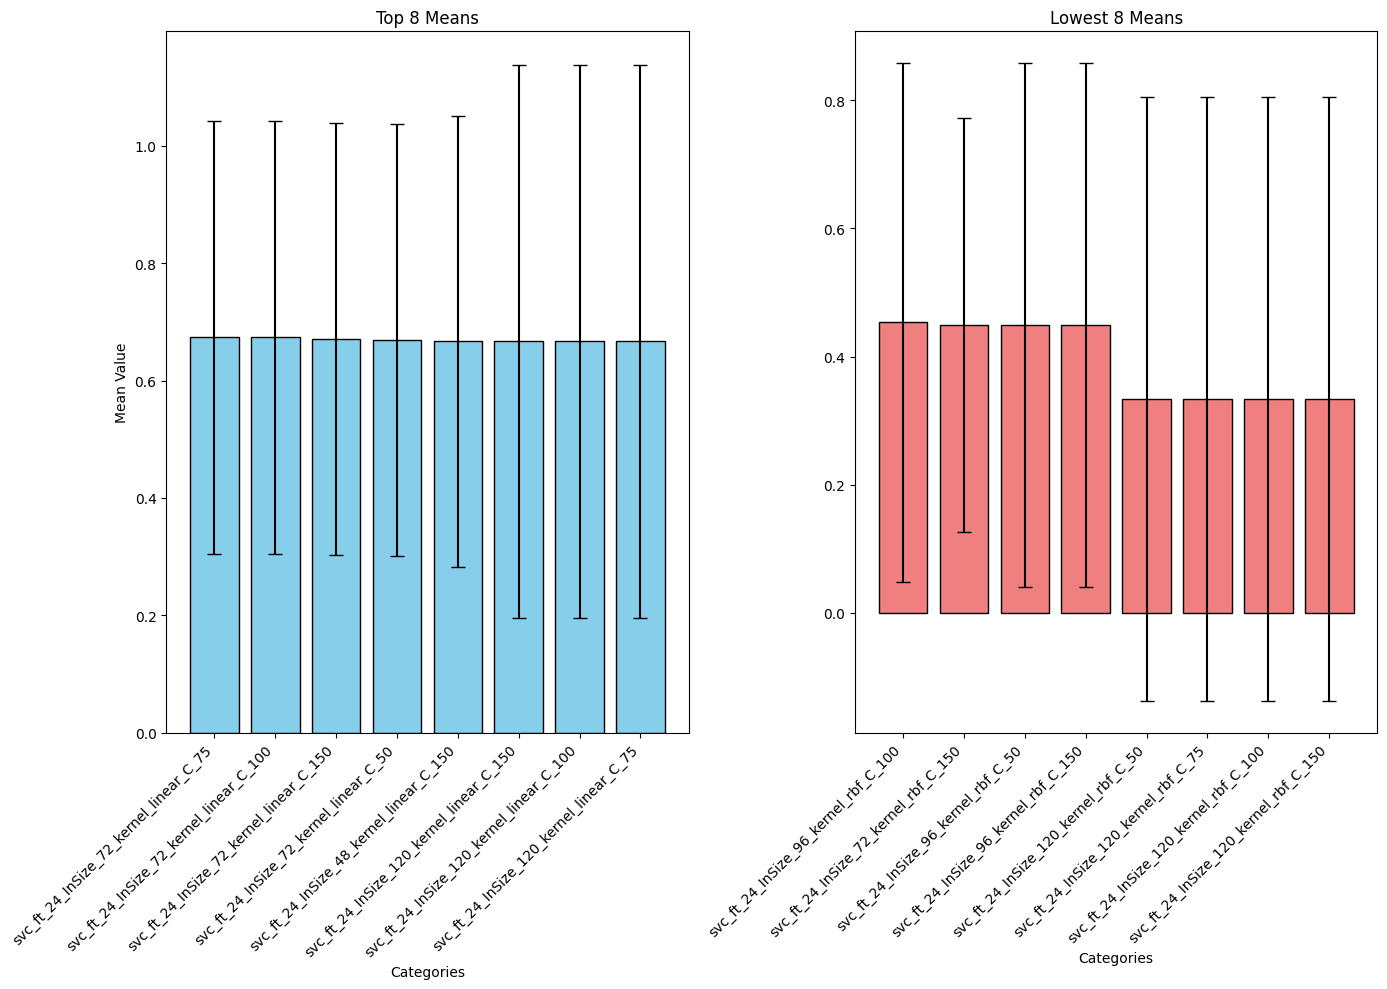

In [ ]:
# Set the size of the figure
fig, axs = plt.subplots(1, 2, figsize=(14, 10))

# Plot the top five means in the left figure
bars_left = axs[0].bar(df_sorted.head(8).index, df_sorted['Mean'].head(8), yerr=df_sorted['Std'].head(8).values.T, capsize=5, color='skyblue', edgecolor='black')
axs[0].set_title('Top 8 Means')
axs[0].set_ylabel('Mean Value')

# Plot the lowest five means in the right figure
bars_right = axs[1].bar(df_sorted.tail(8).index, df_sorted['Mean'].tail(8), yerr=df_sorted['Std'].tail(8).values.T, capsize=5, color='lightcoral', edgecolor='black')
axs[1].set_title('Lowest 8 Means')

# Rotate x-axis labels at 45 degrees for better readability
for ax in axs:
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

# Adding major axis labels to the left figure
axs[0].set_xlabel('Categories')
axs[0].set_ylabel('Mean Value')

# Adding major axis labels to the right figure
axs[1].set_xlabel('Categories')

# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()

# Random Forest Classifier

In [ ]:
# Import necessary libraries
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score
import pandas as pd
import numpy as np

# Specify the hyper-parameters to try
in_sizes = [48, 72, 96, 120]
n_estimators = [75,100, 150, 200]  # Number of trees in the forest
max_depths = [10, 20, 30, 40] # Maximum depth of each tree
doScale = True
# Forecast horizon - 24 time steps in the future (one week ahead)
fh = 24



In [ ]:
# Manually keep track of results of temporal CV
scores = []
names = []
sum_confusion_matrices = []
dat = df_secondHigheststd[df_secondHigheststd.columns[0]].copy()
# Grid search over all hyper-parameter combinations
for ins in in_sizes: # number of predictor inputs
    for n_estimator in n_estimators: # number of trees
        for max_depth in max_depths: # maximum depth of the tree
            cv = list(splitter.split(dat))
            tmp_score = []
            names += [["rf", "ft_" + str(fh),
                       "InSize_" + str(ins),
                       "n_estimators_" + str(n_estimator),
                       "max_depth_" + str(max_depth if max_depth is not None else 'None')]]
            confusion_matrices = []
            for fold in cv: # iterate over the folds of CV
                trn_data = series_to_tabular(dat[fold[0]], n_in=ins, fh=fh)
                trn_data = make_class_labels(trn_data, cls_boundaries, ["Low", "Medium", "High"])
                tst_data = series_to_tabular(dat[fold[1]], n_in=ins, fh=fh)
                tst_data = make_class_labels(tst_data, cls_boundaries, ["Low", "Medium", "High"])

                if doScale:
                    classifier = make_pipeline(StandardScaler(), RandomForestClassifier(n_estimators=n_estimator, max_depth=max_depth))
                else:
                    classifier = RandomForestClassifier(n_estimators=n_estimator, max_depth=max_depth)

                classifier.fit(trn_data.iloc[:, :ins].values, trn_data['Class'])
                y_pred = classifier.predict(tst_data.iloc[:, :ins].values)
                cm = confusion_matrix(tst_data['Class'], y_pred, labels=["Low", "Medium", "High"])
                confusion_matrices += [cm]
                tmp_score += [accuracy_score(tst_data['Class'], y_pred)]
            scores += [tmp_score]
            sum_confusion_matrices += [sum(confusion_matrices)]

# Calculate mean and standard deviation of scores
res = np.concatenate((np.mean(np.vstack(scores), axis=1).reshape(-1, 1),
                      np.std(np.vstack(scores), axis=1).reshape(-1, 1)), axis=1)
resDf = pd.DataFrame(res)
resDf.columns = ['Mean', 'Std']
namesDf = pd.DataFrame(names)
resDf = pd.concat([namesDf, resDf], axis=1)
resDf


,0,1,2,3,4,Mean,Std
0,rf,ft_24,InSize_48,n_estimators_75,max_depth_10,0.490107,0.300939
1,rf,ft_24,InSize_48,n_estimators_75,max_depth_20,0.490107,0.299898
2,rf,ft_24,InSize_48,n_estimators_75,max_depth_30,0.500761,0.306386
3,rf,ft_24,InSize_48,n_estimators_75,max_depth_40,0.490107,0.302184
4,rf,ft_24,InSize_48,n_estimators_100,max_depth_10,0.473364,0.291030
...,...,...,...,...,...,...,...
59,rf,ft_24,InSize_120,n_estimators_150,max_depth_40,0.111111,0.314270
60,rf,ft_24,InSize_120,n_estimators_200,max_depth_10,0.111111,0.314270
61,rf,ft_24,InSize_120,n_estimators_200,max_depth_20,0.222222,0.415740
62,rf,ft_24,InSize_120,n_estimators_200,max_depth_30,0.111111,0.314270


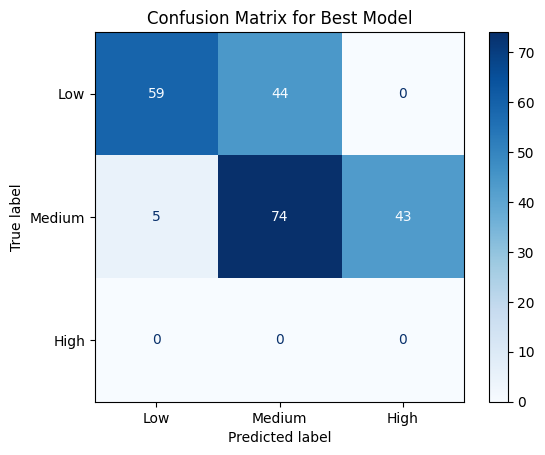

In [ ]:
best_model_idx = np.argmax(np.mean(np.vstack(scores), axis=1))
best_confusion_matrix = sum_confusion_matrices[best_model_idx]

# Create a confusion matrix display for the best model
disp = ConfusionMatrixDisplay(confusion_matrix=best_confusion_matrix, display_labels=["Low", "Medium", "High"])

# Plot the confusion matrix for the best model
disp.plot(cmap='Blues')
plt.title("Confusion Matrix for Best Model")
plt.show()


In [ ]:
resDf['Model_Setup'] = resDf.iloc[:, :5].apply(lambda row: '_'.join(row.astype(str)), axis=1)

# Set the new column as the index if desired
resDf.set_index('Model_Setup', inplace=True)


# Drop the first 5 columns
resDf.drop(resDf.columns[:5], axis=1, inplace=True)

df_sorted = resDf.sort_values(by='Mean', ascending=False)

df_sorted

,Mean,Std
Model_Setup,,
rf_ft_24_InSize_96_n_estimators_150_max_depth_20,0.591111,0.374179
rf_ft_24_InSize_96_n_estimators_100_max_depth_30,0.586667,0.352767
rf_ft_24_InSize_96_n_estimators_100_max_depth_10,0.573333,0.345640
rf_ft_24_InSize_96_n_estimators_200_max_depth_20,0.573333,0.371424
rf_ft_24_InSize_96_n_estimators_100_max_depth_40,0.555556,0.343288
...,...,...
rf_ft_24_InSize_120_n_estimators_100_max_depth_40,0.111111,0.314270
rf_ft_24_InSize_120_n_estimators_150_max_depth_40,0.111111,0.314270
rf_ft_24_InSize_120_n_estimators_75_max_depth_40,0.111111,0.314270


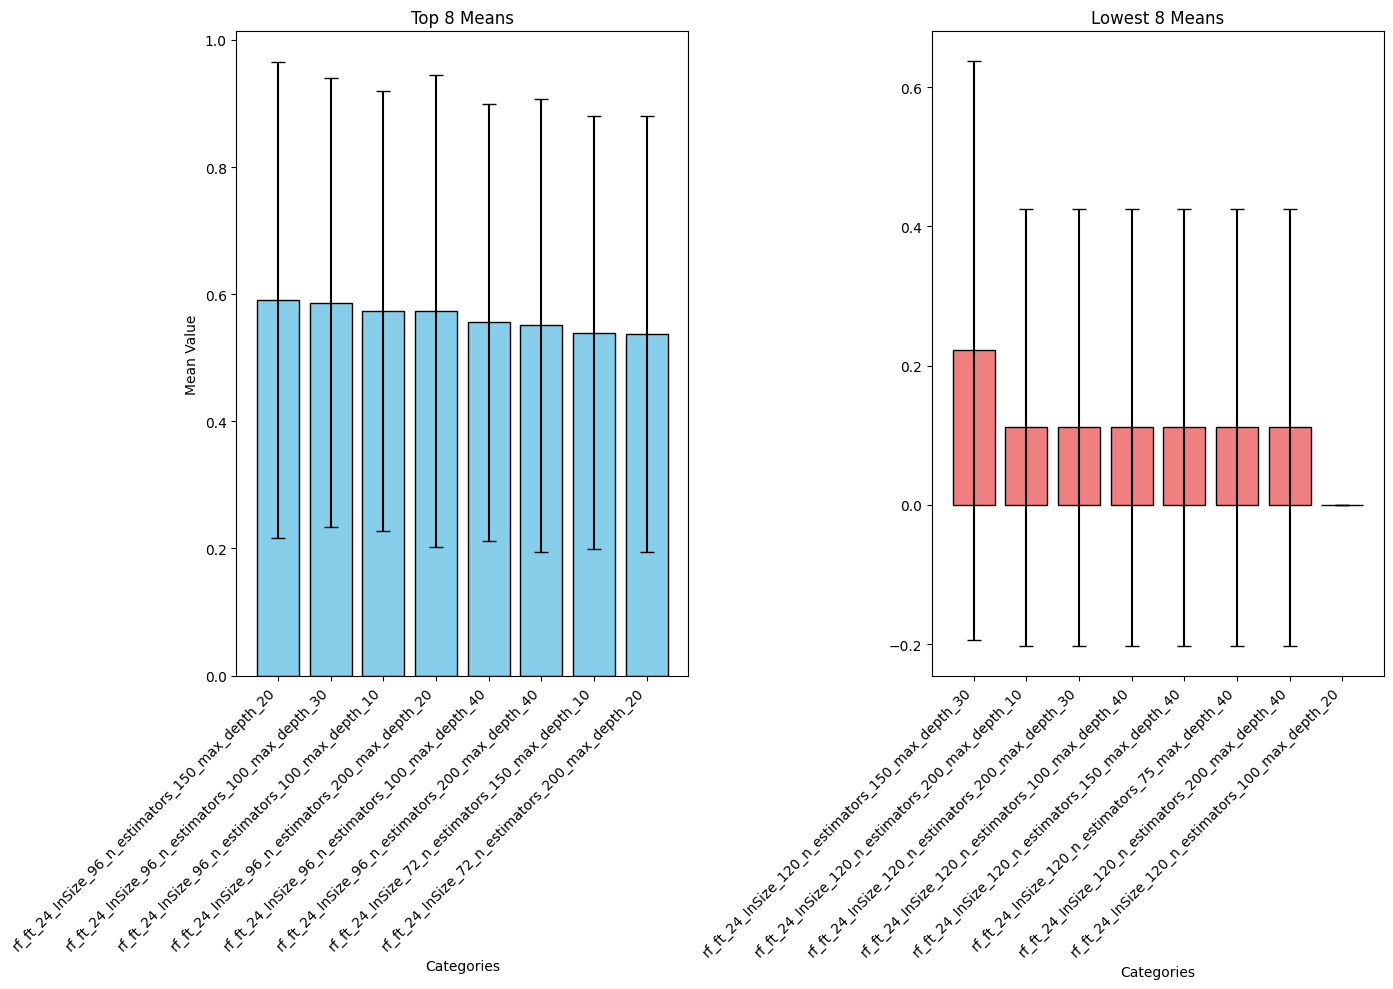

In [ ]:
# Set the size of the figure
fig, axs = plt.subplots(1, 2, figsize=(14, 10))

# Plot the top five means in the left figure
bars_left = axs[0].bar(df_sorted.head(8).index, df_sorted['Mean'].head(8), yerr=df_sorted['Std'].head(8).values.T, capsize=5, color='skyblue', edgecolor='black')
axs[0].set_title('Top 8 Means')
axs[0].set_ylabel('Mean Value')

# Plot the lowest five means in the right figure
bars_right = axs[1].bar(df_sorted.tail(8).index, df_sorted['Mean'].tail(8), yerr=df_sorted['Std'].tail(8).values.T, capsize=5, color='lightcoral', edgecolor='black')
axs[1].set_title('Lowest 8 Means')

# Rotate x-axis labels at 45 degrees for better readability
for ax in axs:
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

# Adding major axis labels to the left figure
axs[0].set_xlabel('Categories')
axs[0].set_ylabel('Mean Value')

# Adding major axis labels to the right figure
axs[1].set_xlabel('Categories')

# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()

# Highest STD

# KNN

In [ ]:
# define equal size classes
cls_boundaries = np.quantile(df_higheststd, [.25, .75])
print("We discretize the data into low, medium and high at " + str(cls_boundaries))

We discretize the data into low, medium and high at [ 3.51472394 13.0904671 ]


In [ ]:
# Specify the hyper-parameters to try
in_sizes = [48,72,96,120]
n_neighbors =  [3,5,7,9]
distances    =  ["euclidean", "dtw"]
doScale = True
# Forecast horizone - 24 time steps in the future (one week ahead)
fh = 24

In [ ]:
# manually keep track of results of temporal CV
scores = []
names = []
sum_confusion_matrices = []
dat = df_higheststd[df_higheststd.columns[0]].copy()
# Grid search over all hyper-parameter combinations
for ins in in_sizes: # number of predictor inputs
  for nn in n_neighbors: # number of nearest neigbours to use
    for dist in distances: # distance function to use
      cv = list(splitter.split(dat))
      tmp_score = []
      names += [["knn", "ft_" + str(fh),
                 "InSize_" + str(ins),
                 "nn_" + str(nn),
                 "distance_" + dist]]
      confusion_matrices = []
      for fold in cv: #iterate over the folds of CV
        trn_data = series_to_tabular(dat[fold[0]],
                                     n_in=ins,
                                     fh=fh) #tabularize the training data
        trn_data =  make_class_labels(trn_data,
                                      cls_boundaries,
                                       ["Low", "Medium", "High"]) # discretize the training targets
        tst_data = series_to_tabular(dat[fold[1]],
                                     n_in=ins,
                                     fh=fh) # discretize the testing targets
        tst_data =  make_class_labels(tst_data,
                                      cls_boundaries,
                                       ["Low", "Medium", "High"]) #tabularize the testing data

        if doScale:
          #make a pipeline to scale the data and train kNN classifier
          classifier = make_pipeline(StandardScaler(),
                                     KNeighborsTimeSeriesClassifier(n_neighbors=nn,
                                                                    distance=dist))
        else:
          #make a pipeline to scale the data and train kNN classifier
          classifier = make_pipeline(KNeighborsTimeSeriesClassifier(n_neighbors=nn,
                                                                    distance=dist))
        #fit the classifier
        classifier.fit(trn_data.iloc[:,:ins].values, trn_data['Class'])
        #make predictions and calculate test accuracy
        y_pred = classifier.predict(tst_data.iloc[:,:ins].values)
        cm = confusion_matrix(tst_data['Class'], y_pred, labels=["Low", "Medium", "High"])
        confusion_matrices += [cm]

        tmp_score += [accuracy_score(tst_data['Class'], y_pred)]
      scores += [tmp_score]
      sum_confusion_matrices += [sum(confusion_matrices)]

res = np.concatenate((np.mean(np.vstack(scores),axis=1).reshape(-1,1),
                      np.std(np.vstack(scores),axis=1).reshape(-1,1)),axis=1)
resDf = pd.DataFrame(res)
resDf.columns = ['Mean', 'Std']
namesDf = pd.DataFrame(names)
resDf = pd.concat([namesDf, resDf], axis=1)
resDf

,0,1,2,3,4,Mean,Std
0,knn,ft_24,InSize_48,nn_3,distance_euclidean,0.325723,0.233527
1,knn,ft_24,InSize_48,nn_3,distance_dtw,0.395738,0.273702
2,knn,ft_24,InSize_48,nn_5,distance_euclidean,0.322679,0.235513
3,knn,ft_24,InSize_48,nn_5,distance_dtw,0.388128,0.272905
4,knn,ft_24,InSize_48,nn_7,distance_euclidean,0.319635,0.229948
5,knn,ft_24,InSize_48,nn_7,distance_dtw,0.374429,0.270757
6,knn,ft_24,InSize_48,nn_9,distance_euclidean,0.319635,0.230763
7,knn,ft_24,InSize_48,nn_9,distance_dtw,0.377473,0.273905
8,knn,ft_24,InSize_72,nn_3,distance_euclidean,0.344671,0.290285
9,knn,ft_24,InSize_72,nn_3,distance_dtw,0.278912,0.304683


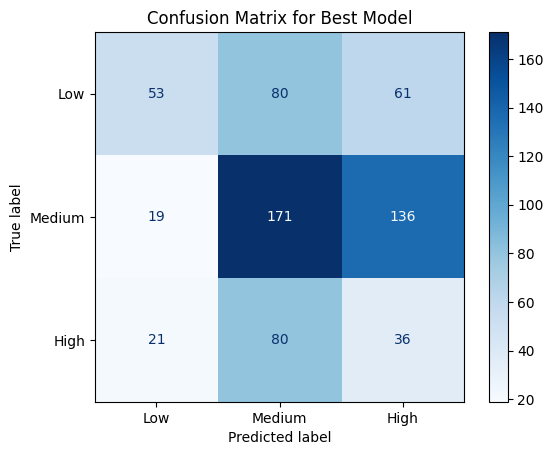

In [ ]:
best_model_idx = np.argmax(np.mean(np.vstack(scores), axis=1))
best_confusion_matrix = sum_confusion_matrices[best_model_idx]

# Create a confusion matrix display for the best model
disp = ConfusionMatrixDisplay(confusion_matrix=best_confusion_matrix, display_labels=["Low", "Medium", "High"])

# Plot the confusion matrix for the best model
disp.plot(cmap='Blues')
plt.title("Confusion Matrix for Best Model")
plt.show()


In [ ]:
resDf['Model_Setup'] = resDf.iloc[:, :5].apply(lambda row: '_'.join(row.astype(str)), axis=1)

# Set the new column as the index if desired
resDf.set_index('Model_Setup', inplace=True)


# Drop the first 5 columns
resDf.drop(resDf.columns[:5], axis=1, inplace=True)

df_sorted = resDf.sort_values(by='Mean', ascending=False)

df_sorted

,Mean,Std
Model_Setup,,
knn_ft_24_InSize_48_nn_3_distance_dtw,0.395738,0.273702
knn_ft_24_InSize_48_nn_5_distance_dtw,0.388128,0.272905
knn_ft_24_InSize_48_nn_9_distance_dtw,0.377473,0.273905
knn_ft_24_InSize_48_nn_7_distance_dtw,0.374429,0.270757
knn_ft_24_InSize_96_nn_3_distance_euclidean,0.373333,0.367091
knn_ft_24_InSize_96_nn_9_distance_euclidean,0.373333,0.367091
knn_ft_24_InSize_96_nn_7_distance_euclidean,0.373333,0.367091
knn_ft_24_InSize_96_nn_5_distance_euclidean,0.373333,0.367091
knn_ft_24_InSize_72_nn_9_distance_euclidean,0.346939,0.294173


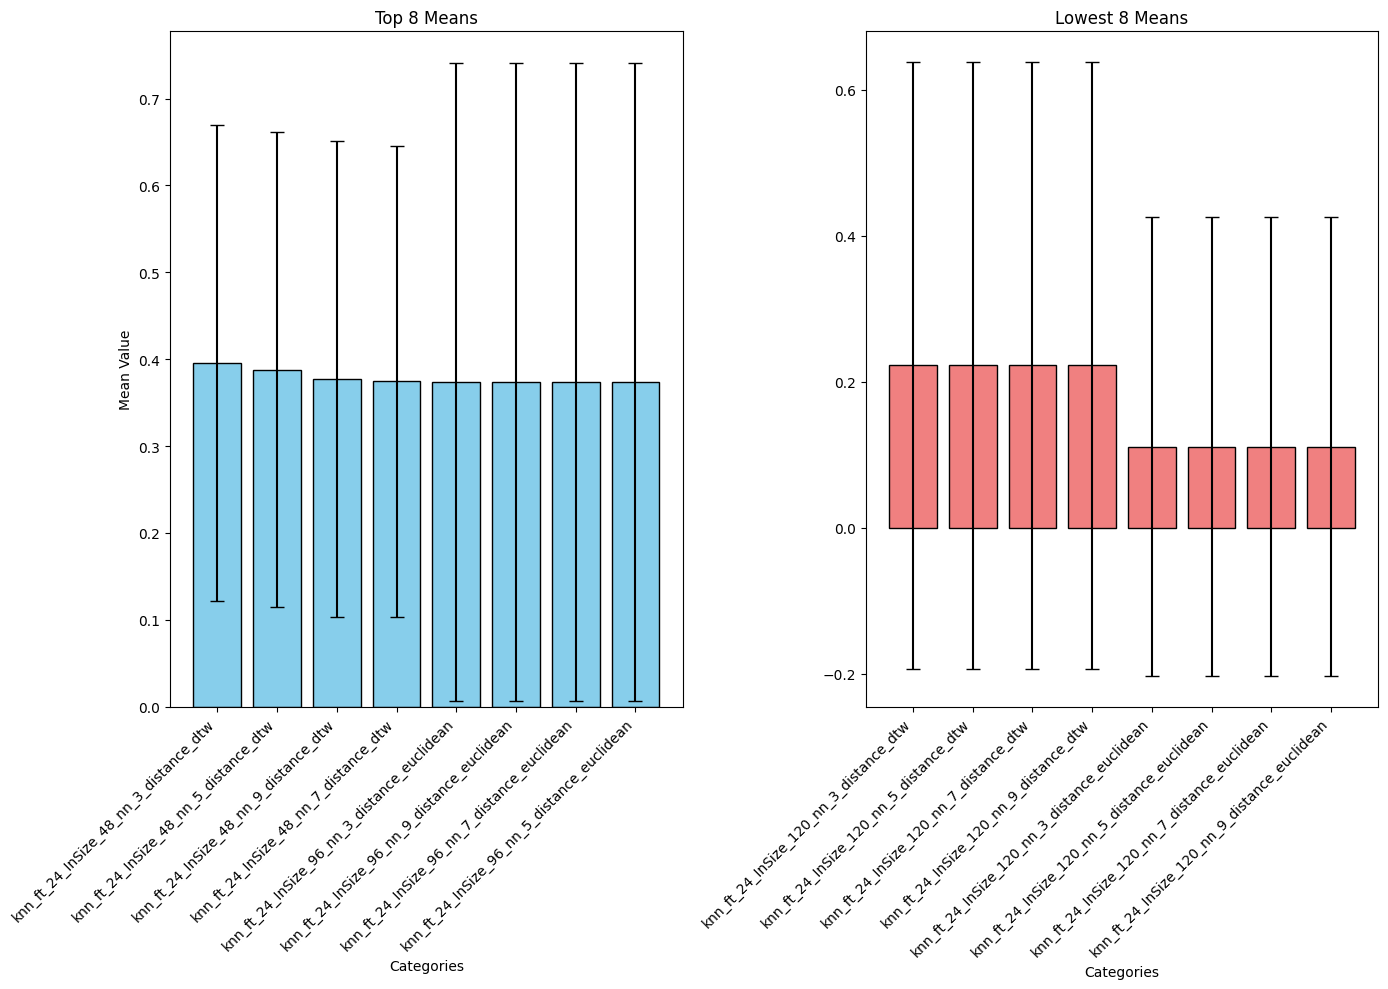

In [ ]:
# Set the size of the figure
fig, axs = plt.subplots(1, 2, figsize=(14, 10))

# Plot the top five means in the left figure
bars_left = axs[0].bar(df_sorted.head(8).index, df_sorted['Mean'].head(8), yerr=df_sorted['Std'].head(8).values.T, capsize=5, color='skyblue', edgecolor='black')
axs[0].set_title('Top 8 Means')
axs[0].set_ylabel('Mean Value')

# Plot the lowest five means in the right figure
bars_right = axs[1].bar(df_sorted.tail(8).index, df_sorted['Mean'].tail(8), yerr=df_sorted['Std'].tail(8).values.T, capsize=5, color='lightcoral', edgecolor='black')
axs[1].set_title('Lowest 8 Means')

# Rotate x-axis labels at 45 degrees for better readability
for ax in axs:
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

# Adding major axis labels to the left figure
axs[0].set_xlabel('Categories')
axs[0].set_ylabel('Mean Value')

# Adding major axis labels to the right figure
axs[1].set_xlabel('Categories')

# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()

# SVM

In [ ]:
# Import necessary libraries
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score
import pandas as pd
import numpy as np

# Specify the hyper-parameters to try
in_sizes = [48, 72, 96, 120]
kernels = ['linear', 'rbf']
Cs = [150,200,250,300]
doScale = True
# Forecast horizon - 24 time steps in the future (one week ahead)
fh = 24



In [ ]:
# Manually keep track of results of temporal CV
scores = []
names = []
sum_confusion_matrices = []
dat = df_higheststd[df_higheststd.columns[0]].copy()
# Grid search over all hyper-parameter combinations
for ins in in_sizes: # number of predictor inputs
    for kernel in kernels: # kernel types
        for C in Cs: # regularization parameter
            cv = list(splitter.split(dat))
            tmp_score = []
            names += [["svc", "ft_" + str(fh),
                       "InSize_" + str(ins),
                       "kernel_" + kernel,
                       "C_" + str(C)]]
            confusion_matrices = []
            for fold in cv: # iterate over the folds of CV
                trn_data = series_to_tabular(dat[fold[0]], n_in=ins, fh=fh)
                trn_data = make_class_labels(trn_data, cls_boundaries, ["Low", "Medium", "High"])
                tst_data = series_to_tabular(dat[fold[1]], n_in=ins, fh=fh)
                tst_data = make_class_labels(tst_data, cls_boundaries, ["Low", "Medium", "High"])

                if doScale:
                    classifier = make_pipeline(StandardScaler(), SVC(kernel=kernel, C=C))
                else:
                    classifier = SVC(kernel=kernel, C=C)

                classifier.fit(trn_data.iloc[:, :ins].values, trn_data['Class'])
                y_pred = classifier.predict(tst_data.iloc[:, :ins].values)
                cm = confusion_matrix(tst_data['Class'], y_pred, labels=["Low", "Medium", "High"])
                confusion_matrices += [cm]
                tmp_score += [accuracy_score(tst_data['Class'], y_pred)]
            scores += [tmp_score]
            sum_confusion_matrices += [sum(confusion_matrices)]

# Calculate mean and standard deviation of scores
res = np.concatenate((np.mean(np.vstack(scores), axis=1).reshape(-1, 1),
                      np.std(np.vstack(scores), axis=1).reshape(-1, 1)), axis=1)
resDf = pd.DataFrame(res)
resDf.columns = ['Mean', 'Std']
namesDf = pd.DataFrame(names)
resDf = pd.concat([namesDf, resDf], axis=1)
resDf


,0,1,2,3,4,Mean,Std
0,svc,ft_24,InSize_48,kernel_linear,C_150,0.672755,0.263850
1,svc,ft_24,InSize_48,kernel_linear,C_200,0.674277,0.262371
2,svc,ft_24,InSize_48,kernel_linear,C_250,0.674277,0.262371
3,svc,ft_24,InSize_48,kernel_linear,C_300,0.677321,0.261202
4,svc,ft_24,InSize_48,kernel_rbf,C_150,0.331811,0.303354
5,svc,ft_24,InSize_48,kernel_rbf,C_200,0.339422,0.310555
6,svc,ft_24,InSize_48,kernel_rbf,C_250,0.330289,0.308579
7,svc,ft_24,InSize_48,kernel_rbf,C_300,0.342466,0.310972
8,svc,ft_24,InSize_72,kernel_linear,C_150,0.603175,0.289753
9,svc,ft_24,InSize_72,kernel_linear,C_200,0.609977,0.285138


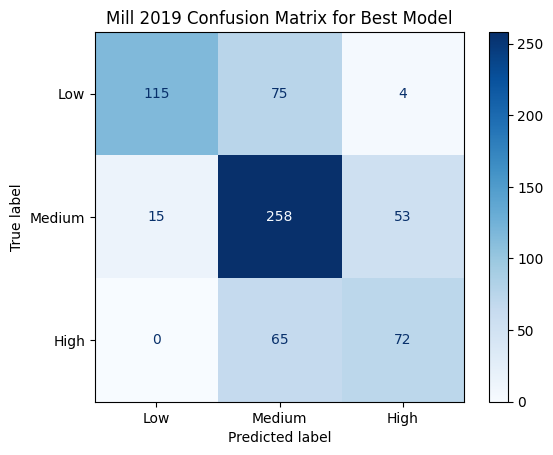

In [ ]:
best_model_idx = np.argmax(np.mean(np.vstack(scores), axis=1))
best_confusion_matrix = sum_confusion_matrices[best_model_idx]

# Create a confusion matrix display for the best model
disp = ConfusionMatrixDisplay(confusion_matrix=best_confusion_matrix, display_labels=["Low", "Medium", "High"])

# Plot the confusion matrix for the best model
disp.plot(cmap='Blues')
plt.title("Mill 2019 Confusion Matrix for Best Model")
plt.show()


In [ ]:
resDf['Model_Setup'] = resDf.iloc[:, :5].apply(lambda row: '_'.join(row.astype(str)), axis=1)

# Set the new column as the index if desired
resDf.set_index('Model_Setup', inplace=True)


# Drop the first 5 columns
resDf.drop(resDf.columns[:5], axis=1, inplace=True)

df_sorted = resDf.sort_values(by='Mean', ascending=False)

df_sorted

,Mean,Std
Model_Setup,,
svc_ft_24_InSize_48_kernel_linear_C_300,0.677321,0.261202
svc_ft_24_InSize_48_kernel_linear_C_200,0.674277,0.262371
svc_ft_24_InSize_48_kernel_linear_C_250,0.674277,0.262371
svc_ft_24_InSize_48_kernel_linear_C_150,0.672755,0.263850
svc_ft_24_InSize_120_kernel_linear_C_300,0.666667,0.471405
svc_ft_24_InSize_120_kernel_linear_C_250,0.666667,0.471405
svc_ft_24_InSize_120_kernel_linear_C_200,0.666667,0.471405
svc_ft_24_InSize_120_kernel_linear_C_150,0.666667,0.471405
svc_ft_24_InSize_72_kernel_linear_C_250,0.623583,0.303939


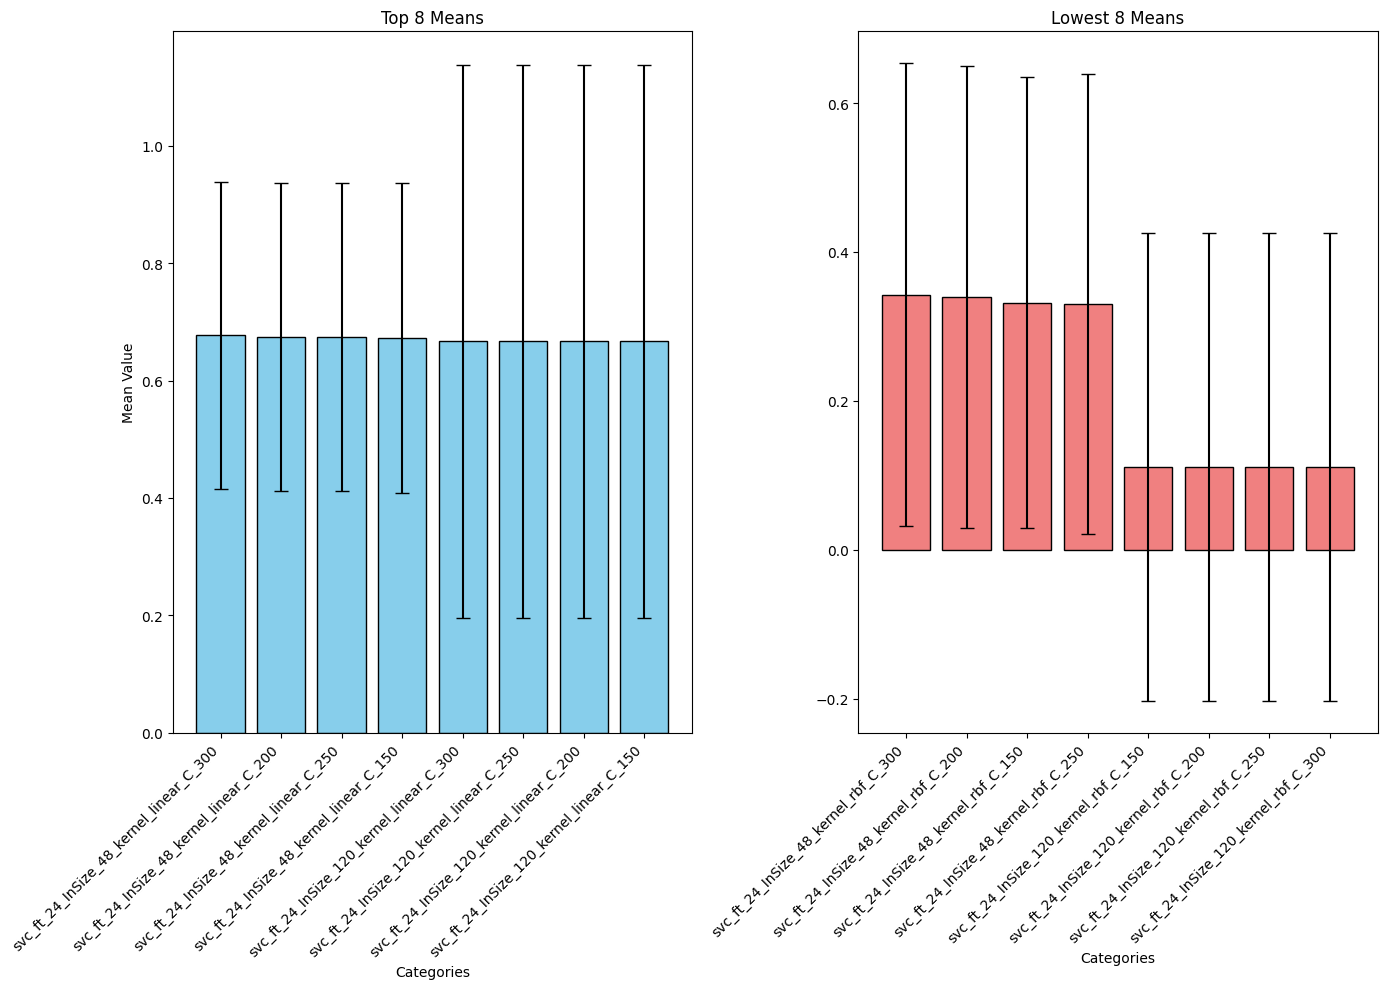

In [ ]:
# Set the size of the figure
fig, axs = plt.subplots(1, 2, figsize=(14, 10))

# Plot the top five means in the left figure
bars_left = axs[0].bar(df_sorted.head(8).index, df_sorted['Mean'].head(8), yerr=df_sorted['Std'].head(8).values.T, capsize=5, color='skyblue', edgecolor='black')
axs[0].set_title('Top 8 Means')
axs[0].set_ylabel('Mean Value')

# Plot the lowest five means in the right figure
bars_right = axs[1].bar(df_sorted.tail(8).index, df_sorted['Mean'].tail(8), yerr=df_sorted['Std'].tail(8).values.T, capsize=5, color='lightcoral', edgecolor='black')
axs[1].set_title('Lowest 8 Means')

# Rotate x-axis labels at 45 degrees for better readability
for ax in axs:
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

# Adding major axis labels to the left figure
axs[0].set_xlabel('Categories')
axs[0].set_ylabel('Mean Value')

# Adding major axis labels to the right figure
axs[1].set_xlabel('Categories')

# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()

# Random Forest Classifier

In [ ]:
# Import necessary libraries
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score
import pandas as pd
import numpy as np

# Specify the hyper-parameters to try
in_sizes = [48, 72, 96, 120]
n_estimators = [200, 250, 300,350]  # Number of trees in the forest
max_depths = [20, 30, 35, 40] # Maximum depth of each tree
doScale = True
# Forecast horizon - 24 time steps in the future (one week ahead)
fh = 24



In [ ]:
# Manually keep track of results of temporal CV
scores = []
names = []
sum_confusion_matrices = []
dat = df_higheststd[df_higheststd.columns[0]].copy()
# Grid search over all hyper-parameter combinations
for ins in in_sizes: # number of predictor inputs
    for n_estimator in n_estimators: # number of trees
        for max_depth in max_depths: # maximum depth of the tree
            cv = list(splitter.split(dat))
            tmp_score = []
            names += [["rf", "ft_" + str(fh),
                       "InSize_" + str(ins),
                       "n_estimators_" + str(n_estimator),
                       "max_depth_" + str(max_depth if max_depth is not None else 'None')]]
            confusion_matrices = []
            for fold in cv: # iterate over the folds of CV
                trn_data = series_to_tabular(dat[fold[0]], n_in=ins, fh=fh)
                trn_data = make_class_labels(trn_data, cls_boundaries, ["Low", "Medium", "High"])
                tst_data = series_to_tabular(dat[fold[1]], n_in=ins, fh=fh)
                tst_data = make_class_labels(tst_data, cls_boundaries, ["Low", "Medium", "High"])

                if doScale:
                    classifier = make_pipeline(StandardScaler(), RandomForestClassifier(n_estimators=n_estimator, max_depth=max_depth))
                else:
                    classifier = RandomForestClassifier(n_estimators=n_estimator, max_depth=max_depth)

                classifier.fit(trn_data.iloc[:, :ins].values, trn_data['Class'])
                y_pred = classifier.predict(tst_data.iloc[:, :ins].values)
                cm = confusion_matrix(tst_data['Class'], y_pred, labels=["Low", "Medium", "High"])
                confusion_matrices += [cm]
                tmp_score += [accuracy_score(tst_data['Class'], y_pred)]
            scores += [tmp_score]
            sum_confusion_matrices += [sum(confusion_matrices)]

# Calculate mean and standard deviation of scores
res = np.concatenate((np.mean(np.vstack(scores), axis=1).reshape(-1, 1),
                      np.std(np.vstack(scores), axis=1).reshape(-1, 1)), axis=1)
resDf = pd.DataFrame(res)
resDf.columns = ['Mean', 'Std']
namesDf = pd.DataFrame(names)
resDf = pd.concat([namesDf, resDf], axis=1)
resDf


,0,1,2,3,4,Mean,Std
0,rf,ft_24,InSize_48,n_estimators_200,max_depth_20,0.316591,0.253615
1,rf,ft_24,InSize_48,n_estimators_200,max_depth_30,0.356164,0.249183
2,rf,ft_24,InSize_48,n_estimators_200,max_depth_35,0.334855,0.243265
3,rf,ft_24,InSize_48,n_estimators_200,max_depth_40,0.324201,0.254646
4,rf,ft_24,InSize_48,n_estimators_250,max_depth_20,0.324201,0.256684
...,...,...,...,...,...,...,...
59,rf,ft_24,InSize_120,n_estimators_300,max_depth_40,0.555556,0.496904
60,rf,ft_24,InSize_120,n_estimators_350,max_depth_20,0.444444,0.496904
61,rf,ft_24,InSize_120,n_estimators_350,max_depth_30,0.555556,0.496904
62,rf,ft_24,InSize_120,n_estimators_350,max_depth_35,0.555556,0.496904


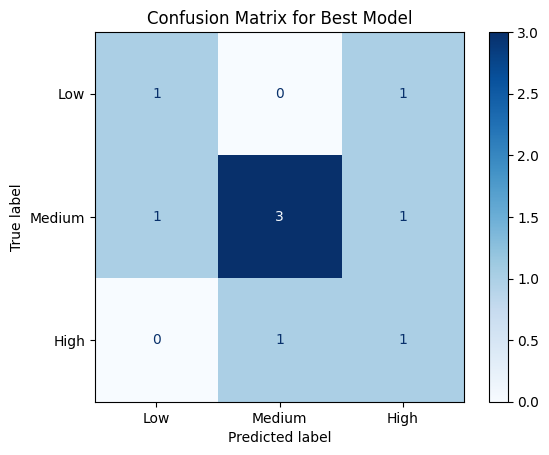

In [ ]:
best_model_idx = np.argmax(np.mean(np.vstack(scores), axis=1))
best_confusion_matrix = sum_confusion_matrices[best_model_idx]

# Create a confusion matrix display for the best model
disp = ConfusionMatrixDisplay(confusion_matrix=best_confusion_matrix, display_labels=["Low", "Medium", "High"])

# Plot the confusion matrix for the best model
disp.plot(cmap='Blues')
plt.title("Confusion Matrix for Best Model")
plt.show()


In [ ]:
resDf['Model_Setup'] = resDf.iloc[:, :5].apply(lambda row: '_'.join(row.astype(str)), axis=1)

# Set the new column as the index if desired
resDf.set_index('Model_Setup', inplace=True)


# Drop the first 5 columns
resDf.drop(resDf.columns[:5], axis=1, inplace=True)

df_sorted = resDf.sort_values(by='Mean', ascending=False)

df_sorted

,Mean,Std
Model_Setup,,
rf_ft_24_InSize_120_n_estimators_350_max_depth_40,0.555556,0.496904
rf_ft_24_InSize_120_n_estimators_350_max_depth_35,0.555556,0.496904
rf_ft_24_InSize_120_n_estimators_350_max_depth_30,0.555556,0.496904
rf_ft_24_InSize_120_n_estimators_300_max_depth_40,0.555556,0.496904
rf_ft_24_InSize_120_n_estimators_300_max_depth_20,0.555556,0.496904
...,...,...
rf_ft_24_InSize_48_n_estimators_300_max_depth_40,0.324201,0.254646
rf_ft_24_InSize_48_n_estimators_250_max_depth_20,0.324201,0.256684
rf_ft_24_InSize_48_n_estimators_300_max_depth_35,0.324201,0.255463


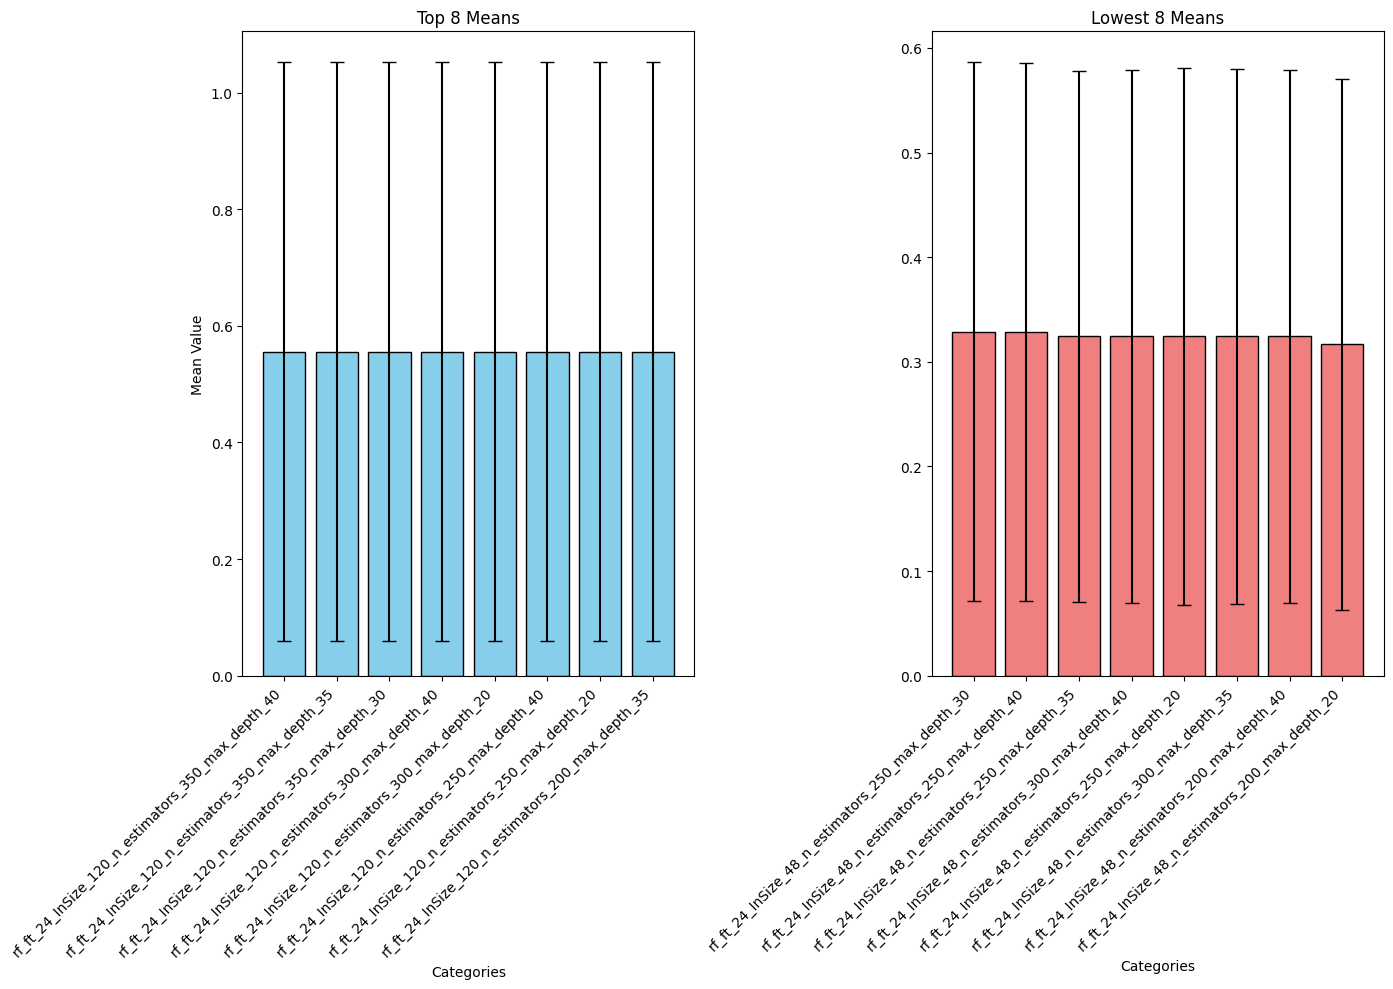

In [ ]:
# Set the size of the figure
fig, axs = plt.subplots(1, 2, figsize=(14, 10))

# Plot the top five means in the left figure
bars_left = axs[0].bar(df_sorted.head(8).index, df_sorted['Mean'].head(8), yerr=df_sorted['Std'].head(8).values.T, capsize=5, color='skyblue', edgecolor='black')
axs[0].set_title('Top 8 Means')
axs[0].set_ylabel('Mean Value')

# Plot the lowest five means in the right figure
bars_right = axs[1].bar(df_sorted.tail(8).index, df_sorted['Mean'].tail(8), yerr=df_sorted['Std'].tail(8).values.T, capsize=5, color='lightcoral', edgecolor='black')
axs[1].set_title('Lowest 8 Means')

# Rotate x-axis labels at 45 degrees for better readability
for ax in axs:
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

# Adding major axis labels to the left figure
axs[0].set_xlabel('Categories')
axs[0].set_ylabel('Mean Value')

# Adding major axis labels to the right figure
axs[1].set_xlabel('Categories')

# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()